# Preferential Bayesian Optimization: Predictive Entropy Search
This notebook demonstrates the use of the Predictive Entropy Search (PES) acquisition function on ordinal (preference) data.

Formulation by Nguyen Quoc Phong.

In [1]:
import numpy as np
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import os
import pickle

from gpflow.utilities import set_trainable, print_summary
gpflow.config.set_default_summary_fmt("notebook")

sys.path.append(os.path.split(os.path.split(os.path.split(os.getcwd())[0])[0])[0]) # Move 3 levels up directory to import PBO
import PBO

In [2]:
objective = PBO.objectives.forrester
objective_low = 0.
objective_high = 1.
objective_name = "Forrester"
acquisition_name = "PES"
experiment_name = "PBO" + "_" + acquisition_name + "_" + objective_name

In [3]:
num_runs = 20
num_evals = 20
num_samples = 100
num_choices = 2
input_dims = 1
num_maximizers = 20
num_init_points = 3
num_inducing_init = 3
num_discrete_per_dim = 10000 # Discretization of continuous input space

In [4]:
results_dir = os.getcwd() + '/results/' + experiment_name + '/'

try:
    # Create target Directory
    os.makedirs(results_dir)
    print("Directory " , results_dir ,  " created ") 
except FileExistsError:
    print("Directory " , results_dir ,  " already exists")

Directory  /home/sebtsh/PBO/notebooks/PES/results/PBO_PES_Forrester/  already exists


Plot of the Forrester function (global min at ~0.757):

(-0.0, 1.0)

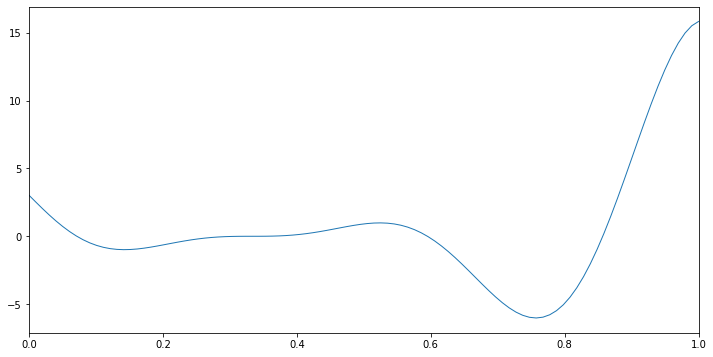

In [5]:
xx = np.linspace(0.0, 1.0, 100).reshape(100, 1)
plt.figure(figsize=(12, 6))
plt.plot(xx, objective(xx), 'C0', linewidth=1)
plt.xlim(-0.0, 1.0)

In [6]:
def plot_gp(model, X, y, title, cmap="Spectral"):
    #Plotting code from GPflow authors

    ## generate test points for prediction
    xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

    ## predict mean and variance of latent GP at test points
    mean, var = model.predict_f(xx)

    ## generate 10 samples from posterior
    samples = model.predict_f_samples(xx, 10)  # shape (10, 100, 1)

    ## plot 
    plt.figure(figsize=(12, 6))
    plt.plot(X, y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                     mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)

    plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
    plt.xlim(-0.1, 1.1)
    plt.title(title)

    plt.savefig(fname=results_dir + title + ".png")

In [7]:
def get_noisy_observation(X, objective):
    f = PBO.objectives.objective_get_f_neg(X, objective)
    return PBO.observation_model.gen_observation_from_f(X, f, 1)

In [8]:
def train_and_visualize(X, y, num_inducing, title):
    
    # Train model with data
    q_mu, q_sqrt, u, inputs, k, indifference_threshold = PBO.models.learning_stochastic.train_model_fullcov(X, y, 
                                                                         num_inducing=num_inducing,
                                                                         obj_low=objective_low,
                                                                         obj_high=objective_high,
                                                                         lengthscale=0.05,
                                                                         num_steps=3000)
    likelihood = gpflow.likelihoods.Gaussian()
    model = PBO.models.learning.init_SVGP_fullcov(q_mu, q_sqrt, u, k, likelihood)
    u_mean = q_mu.numpy()
    inducing_vars = u.numpy()
    
    # Visualize model
    plot_gp(model, inducing_vars, u_mean, title)
    
    return model, inputs, u_mean, inducing_vars

In [9]:
def uniform_grid(input_dims, num_discrete_per_dim, low=0., high=1.):
    """
    Returns an array with all possible permutations of discrete values in input_dims number of dimensions.
    :param input_dims: int
    :param num_discrete_per_dim: int
    :param low: int
    :param high: int
    :return: tensor of shape (num_discrete_per_dim ** input_dims, input_dims)
    """
    num_points = num_discrete_per_dim ** input_dims
    out = np.zeros([num_points, input_dims])
    discrete_points = np.linspace(low, high, num_discrete_per_dim)
    for i in range(num_points):
        for dim in range(input_dims):
            val = num_discrete_per_dim ** (dim)
            out[i, dim] = discrete_points[int((i // val) % num_discrete_per_dim)]
    return out

This function is our main metric for the performance of the acquisition function: The closer the model's best guess to the target (in this case, the global minimum of the Forrester function), the better.

In [10]:
def best_guess(model):
    """
    Returns a GP model's best guess of the global maximum of f.
    """
    xx = uniform_grid(input_dims, num_discrete_per_dim, low=objective_low, high=objective_high)
    res = model.predict_f(xx)[0].numpy()
    return xx[np.argmax(res)]

Store the results in these arrays:

In [11]:
num_data_at_end = int((num_init_points-1) * num_init_points / 2 + num_evals)
X_results = np.zeros([num_runs, num_data_at_end, num_choices, input_dims])
y_results = np.zeros([num_runs, num_data_at_end, 1, input_dims])
best_guess_results = np.zeros([num_runs, num_evals, input_dims])

Create the initial values for each run:

In [12]:
np.random.seed(0)
init_points = np.random.uniform(low=objective_low, high=objective_high, size=[num_runs, num_init_points, input_dims])
num_combs = int((num_init_points-1) * num_init_points / 2)
init_vals = np.zeros([num_runs, num_combs, num_choices, input_dims])
for run in range(num_runs):
    cur_idx = 0
    for init_point in range(num_init_points-1):
        for next_point in range(init_point+1, num_init_points):
            init_vals[run, cur_idx, 0] = init_points[run, init_point]
            init_vals[run, cur_idx, 1] = init_points[run, next_point]
            cur_idx += 1

The following loops carry out the Bayesian optimization algorithm over a number of runs, with a fixed number of evaluations per run.

In [ ]:
for run in range(num_runs):
    print("Beginning run %s" % (run))
    
    X = init_vals[run]
    y = get_noisy_observation(X, objective)
    
    model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, num_inducing_init, "Run_{}:_Initial_model".format(run))

    for evaluation in range(num_evals):
        print("Beginning evaluation %s" % (evaluation)) 

        # Sample possible next queries
        
        samples = PBO.acquisitions.pes.sample_inputs(inputs, num_samples, num_choices, objective_low, objective_high)

        # Sample maximizers
        print("Evaluation %s: Sampling maximizers" % (evaluation))
        maximizers = PBO.fourier_features.sample_maximizers(X=inducing_vars,
                                                            count=num_maximizers,
                                                            n_init=10,
                                                            D=100,
                                                            model=model,
                                                            min_val=objective_low,
                                                            max_val=objective_high)
        print(maximizers)

        # Calculate PES value I for each possible next query
        print("Evaluation %s: Calculating I" % (evaluation))
        I_vals = PBO.acquisitions.pes.I_batch(samples, maximizers, model)

        # Select query that maximizes I
        next_idx = np.argmax(I_vals)
        next_query = samples[next_idx]
        print("Evaluation %s: Next query is %s with I value of %s" % (evaluation, next_query, I_vals[next_idx]))

        X = np.concatenate([X, [next_query]])
        # Evaluate objective function
        y = np.concatenate([y, get_noisy_observation(np.expand_dims(next_query, axis=0), objective)], axis=0)
        
        print("Evaluation %s: Training model" % (evaluation))
        model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, 
                                                                   num_inducing_init + evaluation + 1, 
                                                                   "Run_{}_Evaluation_{}".format(run, evaluation))

        best_guess_results[run, evaluation, :] = best_guess(model)

    X_results[run] = X
    y_results[run] = y

Beginning run 0
Indifference_threshold is trainable.
Instructions for updating:
Use tf.identity instead.
Negative ELBO at step 0: 2.6600908816553397 in 0.1909s
Negative ELBO at step 500: 2.2787567616809383 in 49.3409s
Negative ELBO at step 1000: 2.02900297496264 in 46.8258s
Negative ELBO at step 1500: 2.1363218546672678 in 49.8603s
Negative ELBO at step 2000: 2.041237492303216 in 48.9955s
Negative ELBO at step 2500: 2.153319630170969 in 47.9183s
Beginning evaluation 0
Evaluation 0: Sampling maximizers
Loss at step 0: 21.48986430677004
Loss at step 500: -74.78722991205376
Loss at step 1000: -75.35272521795055
Loss at step 1500: -77.54746445611278
Loss at step 1599: -77.55503703256055
tf.Tensor(
[[0.00674321]
 [0.00202588]
 [0.18413878]
 [1.        ]
 [1.        ]
 [0.        ]
 [0.09760648]
 [0.        ]
 [0.        ]
 [0.60575276]
 [0.13608136]
 [0.10958365]
 [0.45522904]
 [0.84227655]
 [0.        ]
 [0.48533911]
 [0.29301782]
 [0.        ]
 [0.25824225]
 [0.29331884]], shape=(20, 1), 

Loss at step 500: -218.6981635263178
Loss at step 570: -218.71156558721702
tf.Tensor(
[[0.66459558]
 [0.78180133]
 [0.77867784]
 [0.74666648]
 [0.71769898]
 [0.75985283]
 [0.45325507]
 [0.7373436 ]
 [0.7863655 ]
 [0.36599083]
 [0.74578009]
 [0.83576   ]
 [0.75148013]
 [0.83262022]
 [0.80595951]
 [0.90819867]
 [0.73425703]
 [0.73040204]
 [0.75964181]
 [0.91249791]], shape=(20, 1), dtype=float64)
Evaluation 7: Calculating I
Evaluation 7: Next query is tf.Tensor(
[[0.67624248]
 [0.85833764]], shape=(2, 1), dtype=float64) with I value of 0.10425707239058693
Evaluation 7: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 488.85341811105724 in 0.4062s
Negative ELBO at step 500: 9.704886292289883 in 138.0323s
Negative ELBO at step 1000: 7.536099615532839 in 141.1708s
Negative ELBO at step 1500: 6.878002468964733 in 140.9484s
Negative ELBO at step 2000: 6.36582456699366 in 143.7059s
Negative ELBO at step 2500: 6.357100549321436 in 141.4452s
Beginning evaluation 8
Eva

Beginning evaluation 15
Evaluation 15: Sampling maximizers
Loss at step 0: 7.2296614004523665
Loss at step 420: -341.54554486551183
tf.Tensor(
[[0.02241663]
 [0.68287469]
 [0.8579998 ]
 [0.89659413]
 [0.89563071]
 [0.13372013]
 [0.97393738]
 [0.74742145]
 [0.90278196]
 [0.99590346]
 [0.46030881]
 [0.67875691]
 [0.52526968]
 [1.        ]
 [1.        ]
 [0.19216011]
 [0.97974883]
 [0.19781265]
 [0.90539175]
 [0.90300679]], shape=(20, 1), dtype=float64)
Evaluation 15: Calculating I
Evaluation 15: Next query is tf.Tensor(
[[0.75677864]
 [0.90498232]], shape=(2, 1), dtype=float64) with I value of 0.20478060691547784
Evaluation 15: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 55972.05845414879 in 0.6361s
Negative ELBO at step 500: 214.53629483698944 in 226.4828s
Negative ELBO at step 1000: 90.57884531726378 in 225.1710s
Negative ELBO at step 1500: 52.741492012862395 in 229.4617s
Negative ELBO at step 2000: 44.03095460040384 in 226.3134s
Negative ELBO at step 2

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning run 1
Indifference_threshold is trainable.
Negative ELBO at step 0: 3.0627405756603525 in 0.1406s
Negative ELBO at step 500: 2.428877328188231 in 51.2312s
Negative ELBO at step 1000: 2.2449037644298824 in 50.7186s
Negative ELBO at step 1500: 2.154092313855983 in 51.1124s
Negative ELBO at step 2000: 2.079486288906368 in 52.6153s
Negative ELBO at step 2500: 2.0747096053769036 in 50.6075s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 0
Evaluation 0: Sampling maximizers
Loss at step 0: -5.853180573736367
Loss at step 500: -78.5521829037464
Loss at step 884: -79.4525851647044
tf.Tensor(
[[0.71456978]
 [0.29082477]
 [0.        ]
 [0.70992175]
 [0.40230483]
 [1.        ]
 [0.14806673]
 [0.90214245]
 [0.45968242]
 [0.72508697]
 [0.0759603 ]
 [0.70543033]
 [0.9007499 ]
 [0.73291354]
 [1.        ]
 [0.81309004]
 [0.86614845]
 [0.06267477]
 [0.19616415]
 [0.71336105]], shape=(20, 1), dtype=float64)
Evaluation 0: Calculating I
Evaluation 0: Next query is tf.Tensor(
[[0.64589411]
 [0.09671126]], shape=(2, 1), dtype=float64) with I value of 0.050362227037915167
Evaluation 0: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 3.909471264277498 in 0.2299s
Negative ELBO at step 500: 2.945872556158621 in 62.7384s
Negative ELBO at step 1000: 2.7765447665131195 in 62.4011s
Negative ELBO at step 1500: 2.682046272613618 in 63.3022s
Negative ELBO at step 2000: 2.9315586684087096 in 61.593

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 1
Evaluation 1: Sampling maximizers
Loss at step 0: -17.974602303349563
Loss at step 222: -74.1820665716747
tf.Tensor(
[[0.01351767]
 [0.9894479 ]
 [0.63911288]
 [0.65146213]
 [0.84403429]
 [0.84659284]
 [0.84351806]
 [0.05181062]
 [0.64502327]
 [0.84913854]
 [0.98080772]
 [0.84761574]
 [0.98489209]
 [0.64453131]
 [0.84881016]
 [0.85027371]
 [0.98386569]
 [0.65707575]
 [0.64626116]
 [0.84583014]], shape=(20, 1), dtype=float64)
Evaluation 1: Calculating I
Evaluation 1: Next query is tf.Tensor(
[[0.64589411]
 [0.85344933]], shape=(2, 1), dtype=float64) with I value of 0.05015805801607118
Evaluation 1: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 5.906923266853247 in 0.2085s
Negative ELBO at step 500: 3.807971751539095 in 74.5692s
Negative ELBO at step 1000: 3.864356326423079 in 74.6636s
Negative ELBO at step 1500: 3.6419120777827176 in 72.4820s
Negative ELBO at step 2000: 3.7604760719049732 in 73.3075s
Negative ELBO at step 2500: 3.523

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 2
Evaluation 2: Sampling maximizers
Loss at step 0: 5.542289138053034
Loss at step 382: -44.573769311576044
tf.Tensor(
[[0.85446094]
 [0.99406854]
 [1.        ]
 [0.43183077]
 [0.6526144 ]
 [0.8566294 ]
 [0.42379897]
 [0.79714015]
 [0.23205726]
 [0.69044391]
 [0.85338181]
 [0.42234345]
 [0.02555339]
 [1.        ]
 [0.54871899]
 [0.68761205]
 [0.85213436]
 [0.42528714]
 [0.42845515]
 [0.99966994]], shape=(20, 1), dtype=float64)
Evaluation 2: Calculating I
Evaluation 2: Next query is tf.Tensor(
[[0.4236548 ]
 [0.79255517]], shape=(2, 1), dtype=float64) with I value of 0.024558853143418345
Evaluation 2: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 7.305269657182022 in 0.2582s
Negative ELBO at step 500: 3.968216813708371 in 83.4985s
Negative ELBO at step 1000: 3.840032682904871 in 85.1150s
Negative ELBO at step 1500: 3.707768871963988 in 83.5039s
Negative ELBO at step 2000: 3.564883294743674 in 86.8404s
Negative ELBO at step 2500: 3.6751

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 3
Evaluation 3: Sampling maximizers
Loss at step 0: -8.752337601796173
Loss at step 304: -98.0548654306975
tf.Tensor(
[[0.64812824]
 [0.28242863]
 [0.49360489]
 [0.63911956]
 [0.64901168]
 [0.65377926]
 [0.79733022]
 [0.64535364]
 [0.53981366]
 [0.65053297]
 [0.64637952]
 [0.64715143]
 [0.64735643]
 [0.54201466]
 [0.99242688]
 [0.64963152]
 [0.42170009]
 [0.64189594]
 [0.85093146]
 [0.64593111]], shape=(20, 1), dtype=float64)
Evaluation 3: Calculating I
Evaluation 3: Next query is tf.Tensor(
[[0.64589411]
 [0.80354529]], shape=(2, 1), dtype=float64) with I value of 0.05928927530027263
Evaluation 3: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 27.712326843887645 in 0.3072s
Negative ELBO at step 500: 5.0428313468431245 in 95.7037s
Negative ELBO at step 1000: 4.740767260672394 in 94.6859s
Negative ELBO at step 1500: 4.856838671697555 in 98.8910s
Negative ELBO at step 2000: 4.832529326551569 in 95.6301s
Negative ELBO at step 2500: 4.7839

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 4
Evaluation 4: Sampling maximizers
Loss at step 0: -2.5792306537059373
Loss at step 352: -103.12155688041175
tf.Tensor(
[[0.73783161]
 [0.3327618 ]
 [0.33024107]
 [0.8008918 ]
 [0.69528409]
 [0.79199853]
 [0.64904087]
 [0.10483508]
 [0.32256315]
 [0.77851253]
 [0.65790095]
 [0.79709952]
 [0.65618633]
 [0.33029634]
 [0.68305402]
 [0.67513951]
 [0.6325831 ]
 [0.62605349]
 [0.6818663 ]
 [0.65673436]], shape=(20, 1), dtype=float64)
Evaluation 4: Calculating I
Evaluation 4: Next query is tf.Tensor(
[[0.64589411]
 [0.73045607]], shape=(2, 1), dtype=float64) with I value of 0.0622205851200563
Evaluation 4: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 13.988315830551956 in 0.3377s
Negative ELBO at step 500: 5.790440599603278 in 105.6198s
Negative ELBO at step 1000: 5.553034773806305 in 106.6733s
Negative ELBO at step 1500: 5.447652576470375 in 108.6827s
Negative ELBO at step 2000: 5.5040166203044265 in 106.3605s
Negative ELBO at step 2500: 

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 5
Evaluation 5: Sampling maximizers
Loss at step 0: -5.369482764276137
Loss at step 500: -161.83406254991164
Loss at step 719: -163.44934333726928
tf.Tensor(
[[0.7043185 ]
 [0.79615299]
 [0.67521824]
 [0.85699144]
 [0.69277973]
 [0.6253223 ]
 [0.36780407]
 [0.7211266 ]
 [0.70735682]
 [0.40005599]
 [0.84997219]
 [0.07332535]
 [0.78746361]
 [0.26044575]
 [0.66349239]
 [0.72800984]
 [0.12242821]
 [0.71473272]
 [0.63511098]
 [0.74597054]], shape=(20, 1), dtype=float64)
Evaluation 5: Calculating I
Evaluation 5: Next query is tf.Tensor(
[[0.73045607]
 [0.3011552 ]], shape=(2, 1), dtype=float64) with I value of 0.060123066616109735
Evaluation 5: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 77321.6743234323 in 0.2857s
Negative ELBO at step 500: 368.6367640902285 in 118.8407s
Negative ELBO at step 1000: 129.44088171470622 in 117.9592s
Negative ELBO at step 1500: 91.88482359571972 in 117.3820s
Negative ELBO at step 2000: 69.29243199595216 in 1

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 6
Evaluation 6: Sampling maximizers
Loss at step 0: 34.90178829206408
Loss at step 231: -401.55727206888014
tf.Tensor(
[[0.93160999]
 [0.26717346]
 [0.6618474 ]
 [0.96756605]
 [0.12916459]
 [0.41197574]
 [0.771282  ]
 [0.4966957 ]
 [0.95705556]
 [0.70277147]
 [0.96860753]
 [0.4745392 ]
 [0.97505866]
 [0.96852893]
 [0.64570559]
 [0.65277482]
 [0.13028771]
 [0.9742317 ]
 [0.50233932]
 [0.70143407]], shape=(20, 1), dtype=float64)
Evaluation 6: Calculating I
Evaluation 6: Next query is tf.Tensor(
[[0.79255517]
 [0.93686283]], shape=(2, 1), dtype=float64) with I value of 0.2371734986827781
Evaluation 6: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 25.549146791528628 in 0.3805s
Negative ELBO at step 500: 7.315330134170261 in 127.4264s
Negative ELBO at step 1000: 6.897964317973993 in 128.7295s
Negative ELBO at step 1500: 6.794251497812314 in 129.2963s
Negative ELBO at step 2000: 6.472947889041102 in 128.3327s
Negative ELBO at step 2500: 6.1

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 7
Evaluation 7: Sampling maximizers
Loss at step 0: 45.34582920397837
Loss at step 461: -156.38370469824292
tf.Tensor(
[[0.        ]
 [0.74349026]
 [0.00841206]
 [0.63300794]
 [0.72393264]
 [0.7259848 ]
 [0.76464797]
 [0.67427155]
 [0.77288411]
 [0.58367271]
 [0.78258346]
 [0.73919929]
 [0.69045052]
 [0.82430397]
 [0.73156419]
 [0.76570842]
 [0.64058245]
 [0.85348583]
 [0.75745773]
 [0.67543995]], shape=(20, 1), dtype=float64)
Evaluation 7: Calculating I
Evaluation 7: Next query is tf.Tensor(
[[0.80354529]
 [0.67070996]], shape=(2, 1), dtype=float64) with I value of 0.06169499627025463
Evaluation 7: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 118.46539739820214 in 0.4057s
Negative ELBO at step 500: 8.864314859642787 in 141.6553s
Negative ELBO at step 1000: 7.810252016631768 in 141.8049s
Negative ELBO at step 1500: 8.048880912759452 in 141.8373s
Negative ELBO at step 2000: 7.670141895872437 in 142.1843s
Negative ELBO at step 2500: 7.

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 8
Evaluation 8: Sampling maximizers
Loss at step 0: 25.34802895437241
Loss at step 500: -121.08780193957507
Loss at step 615: -126.0065292116398
tf.Tensor(
[[0.17586107]
 [0.81431282]
 [0.760616  ]
 [0.75458587]
 [0.83362251]
 [0.75544941]
 [0.79319058]
 [0.71532835]
 [0.75912882]
 [0.20875851]
 [0.33699228]
 [0.82745908]
 [0.25977244]
 [0.83035967]
 [0.76712707]
 [0.78751648]
 [0.77424844]
 [0.87041162]
 [0.37247972]
 [0.0140069 ]], shape=(20, 1), dtype=float64)
Evaluation 8: Calculating I
Evaluation 8: Next query is tf.Tensor(
[[0.73045607]
 [0.8141587 ]], shape=(2, 1), dtype=float64) with I value of 0.08017155418789004
Evaluation 8: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 6538.5504612664645 in 0.4518s
Negative ELBO at step 500: 65.50069304659172 in 152.7568s
Negative ELBO at step 1000: 35.470838844664755 in 149.7670s
Negative ELBO at step 1500: 23.990510905931092 in 151.0496s
Negative ELBO at step 2000: 17.824949933395096 in 

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 9
Evaluation 9: Sampling maximizers
Loss at step 0: -35.841395172888426
Loss at step 288: -270.21732681740116
tf.Tensor(
[[0.46782875]
 [0.86926204]
 [0.3267848 ]
 [0.32280291]
 [0.71114812]
 [0.79730343]
 [0.3912533 ]
 [1.        ]
 [0.44111547]
 [0.32116713]
 [0.81274804]
 [0.79048913]
 [0.79915345]
 [0.68271675]
 [0.77475791]
 [0.77843507]
 [0.39799655]
 [0.78810979]
 [0.32914147]
 [0.48814602]], shape=(20, 1), dtype=float64)
Evaluation 9: Calculating I
Evaluation 9: Next query is tf.Tensor(
[[0.80354529]
 [0.31146496]], shape=(2, 1), dtype=float64) with I value of 0.18794191944706165
Evaluation 9: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 4916.406920320359 in 0.5650s
Negative ELBO at step 500: 104.39395990356398 in 164.6210s
Negative ELBO at step 1000: 70.30518915459851 in 164.1741s
Negative ELBO at step 1500: 40.534775837363306 in 162.5748s
Negative ELBO at step 2000: 50.73249947039086 in 166.6543s
Negative ELBO at step 2500:

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 10
Evaluation 10: Sampling maximizers
Loss at step 0: 10.143029791072276
Loss at step 299: -291.7974395210679
tf.Tensor(
[[0.38018804]
 [0.59305523]
 [0.02379082]
 [0.50657292]
 [0.19427096]
 [0.69822469]
 [0.16809281]
 [0.7532974 ]
 [0.76234957]
 [0.68603112]
 [0.18918132]
 [0.83212054]
 [0.80416724]
 [0.76856657]
 [0.28552863]
 [0.74958802]
 [0.71665659]
 [0.75743433]
 [0.25788722]
 [0.67916742]], shape=(20, 1), dtype=float64)
Evaluation 10: Calculating I
Evaluation 10: Next query is tf.Tensor(
[[0.3011552 ]
 [0.20308717]], shape=(2, 1), dtype=float64) with I value of 0.2350185512764371
Evaluation 10: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 77.06440331262436 in 0.5257s
Negative ELBO at step 500: 10.197053560739567 in 172.1782s
Negative ELBO at step 1500: 8.782612848095043 in 172.2905s
Negative ELBO at step 2000: 8.568372601498831 in 173.9655s
Negative ELBO at step 2500: 8.587952933954309 in 171.9194s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 11
Evaluation 11: Sampling maximizers
Loss at step 0: 44.05344973524565
Loss at step 289: -119.24192069970898
tf.Tensor(
[[0.37269847]
 [0.58220906]
 [0.78411634]
 [0.76624332]
 [0.86269242]
 [0.7765221 ]
 [0.64818711]
 [0.75751205]
 [0.86360008]
 [0.61655236]
 [0.70192498]
 [0.77691395]
 [0.79922682]
 [0.76931266]
 [0.01288713]
 [0.66439452]
 [0.        ]
 [0.20358296]
 [0.80685839]
 [0.44950706]], shape=(20, 1), dtype=float64)
Evaluation 11: Calculating I
Evaluation 11: Next query is tf.Tensor(
[[0.73045607]
 [0.84508167]], shape=(2, 1), dtype=float64) with I value of 0.05392194207948654
Evaluation 11: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 2450.9013868721004 in 0.6813s
Negative ELBO at step 500: 28.468059522983413 in 183.6424s
Negative ELBO at step 1000: 16.699287116974872 in 185.3529s
Negative ELBO at step 1500: 16.678530556244045 in 185.1176s
Negative ELBO at step 2000: 13.641175041869047 in 182.1188s
Negative ELBO at step

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 12
Evaluation 12: Sampling maximizers
Loss at step 0: -17.875111351339008
Loss at step 231: -223.91523915330575
tf.Tensor(
[[0.77303643]
 [0.72586715]
 [0.76433122]
 [0.45631314]
 [0.72173727]
 [0.37532658]
 [0.36165286]
 [0.79075987]
 [0.19770437]
 [0.03022495]
 [0.1925175 ]
 [0.139191  ]
 [0.47751917]
 [0.80983051]
 [0.78668588]
 [0.60854083]
 [0.78106352]
 [0.70863599]
 [0.82338889]
 [0.6762593 ]], shape=(20, 1), dtype=float64)
Evaluation 12: Calculating I
Evaluation 12: Next query is tf.Tensor(
[[0.73045607]
 [0.20921049]], shape=(2, 1), dtype=float64) with I value of 0.05967103622914885
Evaluation 12: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 16888.75410968072 in 0.6752s
Negative ELBO at step 500: 121.19594413505803 in 191.2031s
Negative ELBO at step 1000: 54.459891835521105 in 195.3682s
Negative ELBO at step 1500: 40.29764685086184 in 196.0137s
Negative ELBO at step 2000: 27.264706497591312 in 195.1720s
Negative ELBO at step

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 13
Evaluation 13: Sampling maximizers
Loss at step 0: 30.350587520703286
Loss at step 458: -325.50549764211416
tf.Tensor(
[[0.76258812]
 [0.65868475]
 [0.68609879]
 [0.        ]
 [0.38986148]
 [0.        ]
 [0.35089783]
 [0.61137856]
 [0.65311522]
 [0.49956434]
 [0.76152055]
 [0.1500395 ]
 [0.65845009]
 [0.61855487]
 [0.68263607]
 [0.6551429 ]
 [0.68778237]
 [0.67195619]
 [0.62849479]
 [1.        ]], shape=(20, 1), dtype=float64)
Evaluation 13: Calculating I
Evaluation 13: Next query is tf.Tensor(
[[0.67070996]
 [0.75825584]], shape=(2, 1), dtype=float64) with I value of 0.21894481272607855
Evaluation 13: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 27887.50900326202 in 0.6265s
Negative ELBO at step 500: 257.3814652771559 in 203.3626s
Negative ELBO at step 1000: 129.01886597482056 in 204.6835s
Negative ELBO at step 1500: 53.94900329162333 in 207.7947s
Negative ELBO at step 2000: 41.53063180696969 in 203.8431s
Negative ELBO at step 25

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 14
Evaluation 14: Sampling maximizers
Loss at step 0: -389.2724327268484
Loss at step 236: -1309.0392558812405
tf.Tensor(
[[0.83821724]
 [0.53725488]
 [0.45963068]
 [0.31603522]
 [0.64677829]
 [0.91374098]
 [0.53442417]
 [0.88733825]
 [0.91112576]
 [0.97966319]
 [0.56878026]
 [0.86128905]
 [0.93452321]
 [0.91934196]
 [0.90121269]
 [0.87169056]
 [0.50334899]
 [0.99199037]
 [0.73234291]
 [0.6439291 ]], shape=(20, 1), dtype=float64)
Evaluation 14: Calculating I
Evaluation 14: Next query is tf.Tensor(
[[0.54488318]
 [0.72064255]], shape=(2, 1), dtype=float64) with I value of 0.2079521005529551
Evaluation 14: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 3485.429807605144 in 0.6048s
Negative ELBO at step 500: 33.619143015795885 in 213.2144s
Negative ELBO at step 1000: 17.492515170738763 in 217.9900s
Negative ELBO at step 1500: 17.26178080527104 in 218.2013s
Negative ELBO at step 2000: 14.46970320032905 in 214.7362s
Negative ELBO at step 25

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 15
Evaluation 15: Sampling maximizers
Loss at step 0: 11013.110346650361
Loss at step 500: -3452.781724893652
Loss at step 663: -3453.1232028684717
tf.Tensor(
[[0.22614672]
 [0.92833002]
 [0.83590135]
 [0.71361265]
 [0.16868416]
 [0.22998932]
 [0.23056964]
 [0.92979279]
 [0.71583294]
 [0.80909761]
 [0.83350709]
 [0.981377  ]
 [0.79615276]
 [0.95090459]
 [0.74638838]
 [0.08294546]
 [0.76520524]
 [1.        ]
 [1.        ]
 [0.61664741]], shape=(20, 1), dtype=float64)
Evaluation 15: Calculating I
Evaluation 15: Next query is tf.Tensor(
[[0.80354529]
 [0.96117044]], shape=(2, 1), dtype=float64) with I value of 0.05700930610521813
Evaluation 15: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 2452856.7954669497 in 0.5999s
Negative ELBO at step 500: 6832.28903444497 in 225.9540s
Negative ELBO at step 1000: 3254.7891732719395 in 228.2679s
Negative ELBO at step 1500: 1932.2085526671724 in 229.0486s
Negative ELBO at step 2000: 1028.190075223766

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 16
Evaluation 16: Sampling maximizers
Loss at step 0: 329754.0961772377
Loss at step 500: -894168.8623262976
Loss at step 553: -894175.6518274205
tf.Tensor(
[[0.10645272]
 [0.10903913]
 [0.10692091]
 [0.01561781]
 [0.11643037]
 [0.20660907]
 [0.01885381]
 [0.90508727]
 [0.        ]
 [0.10799468]
 [0.11877185]
 [0.11158405]
 [0.10616118]
 [0.        ]
 [0.98847866]
 [0.90925273]
 [0.        ]
 [0.11487191]
 [0.13289957]
 [0.        ]], shape=(20, 1), dtype=float64)
Evaluation 16: Calculating I
Evaluation 16: Next query is tf.Tensor(
[[0.96117044]
 [0.13170556]], shape=(2, 1), dtype=float64) with I value of 0.11286210143171295
Evaluation 16: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 133735.60382846964 in 0.6540s
Negative ELBO at step 500: 233.38044982349203 in 238.9609s
Negative ELBO at step 1000: 219.51626687912676 in 240.4349s
Negative ELBO at step 1500: 98.89026643537775 in 239.4104s
Negative ELBO at step 2000: 73.72842477807156 

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 17
Evaluation 17: Sampling maximizers
Loss at step 0: -1955.4442894428748
Loss at step 157: -5898.048757728842
tf.Tensor(
[[0.97177337]
 [0.16806121]
 [0.97421377]
 [0.74520049]
 [0.        ]
 [0.16628616]
 [0.        ]
 [0.78671676]
 [0.03781438]
 [0.2570212 ]
 [0.04181207]
 [0.04002646]
 [0.        ]
 [0.16456909]
 [0.24952623]
 [0.97207183]
 [0.16537832]
 [0.04110483]
 [0.03939718]
 [0.0975166 ]], shape=(20, 1), dtype=float64)
Evaluation 17: Calculating I
Evaluation 17: Next query is tf.Tensor(
[[0.80354529]
 [0.26791819]], shape=(2, 1), dtype=float64) with I value of 0.29192146440532
Evaluation 17: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 38890783.34441689 in 0.7925s
Negative ELBO at step 500: 116679.41739656692 in 247.2924s
Negative ELBO at step 1000: 67982.63280025334 in 252.6287s
Negative ELBO at step 1500: 47808.24485980723 in 247.3747s
Negative ELBO at step 2000: 20702.12089939169 in 250.4286s
Negative ELBO at step 2500:

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 18
Evaluation 18: Sampling maximizers
Loss at step 0: -46301086.59171499
Loss at step 157: -335074280.22825646
tf.Tensor(
[[0.2109786 ]
 [0.88569864]
 [0.88915945]
 [0.88989429]
 [1.        ]
 [0.89395162]
 [1.        ]
 [0.89571922]
 [1.        ]
 [0.79199177]
 [0.89797284]
 [1.        ]
 [1.        ]
 [0.09147126]
 [0.98579734]
 [0.88420111]
 [0.89185779]
 [0.89419757]
 [1.        ]
 [0.7904068 ]], shape=(20, 1), dtype=float64)
Evaluation 18: Calculating I
Evaluation 18: Next query is tf.Tensor(
[[0.75825584]
 [0.62548881]], shape=(2, 1), dtype=float64) with I value of 0.48027403593536655
Evaluation 18: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 397108278.29942733 in 0.7710s
Negative ELBO at step 500: 405439.0491081025 in 264.7970s
Negative ELBO at step 1000: 164561.88749395197 in 265.3184s
Negative ELBO at step 1500: 115579.923397062 in 263.7098s
Negative ELBO at step 2000: 53176.573801515784 in 261.4184s
Negative ELBO at step 2

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 19
Evaluation 19: Sampling maximizers
Loss at step 0: -419563.9886151676
Loss at step 390: -2717847.7378687626
tf.Tensor(
[[0.44170725]
 [0.4406782 ]
 [1.        ]
 [0.01189716]
 [0.34258746]
 [0.34135932]
 [1.        ]
 [0.05561553]
 [0.05451623]
 [0.24814307]
 [1.        ]
 [1.        ]
 [0.33410862]
 [0.05442761]
 [1.        ]
 [0.05259563]
 [0.05312003]
 [0.44238413]
 [0.01146829]
 [0.20798577]], shape=(20, 1), dtype=float64)
Evaluation 19: Calculating I
Evaluation 19: Next query is tf.Tensor(
[[0.4236548 ]
 [0.35546853]], shape=(2, 1), dtype=float64) with I value of 0.579236681711893
Evaluation 19: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 29014692.541173745 in 0.7498s
Negative ELBO at step 500: 103704.04682565303 in 327.9464s
Negative ELBO at step 1000: 58580.62472592284 in 335.5211s
Negative ELBO at step 1500: 28971.525256926947 in 339.6814s
Negative ELBO at step 2000: 18010.230591596697 in 343.0253s
Negative ELBO at step 2

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning run 2
Indifference_threshold is trainable.
Negative ELBO at step 0: 2.727843826616871 in 0.2010s
Negative ELBO at step 500: 2.131148635706273 in 76.4913s
Negative ELBO at step 1000: 2.1831303098385737 in 54.5190s
Negative ELBO at step 1500: 1.8675744224848823 in 65.7636s
Negative ELBO at step 2000: 1.9196973674085158 in 76.4202s
Negative ELBO at step 2500: 1.8619326648083347 in 53.9052s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 0
Evaluation 0: Sampling maximizers
Loss at step 0: -71.47697701435297
Loss at step 500: -229.17375155095056
Loss at step 1000: -241.2622973916976
Loss at step 1500: -243.07515636985187
Loss at step 1776: -243.431380311049
tf.Tensor(
[[0.08349073]
 [0.        ]
 [0.        ]
 [0.43050814]
 [0.44658426]
 [0.48457942]
 [0.05832344]
 [0.        ]
 [0.45230761]
 [0.45245575]
 [0.08222377]
 [0.44872691]
 [0.02830163]
 [0.        ]
 [0.41582331]
 [0.43654917]
 [0.01125314]
 [0.        ]
 [0.        ]
 [0.48739175]], shape=(20, 1), dtype=float64)
Evaluation 0: Calculating I
Evaluation 0: Next query is tf.Tensor(
[[0.43758721]
 [0.02957385]], shape=(2, 1), dtype=float64) with I value of 0.0925126560282146
Evaluation 0: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 4.112744942907424 in 0.1854s
Negative ELBO at step 500: 2.7689884648756973 in 78.2634s
Negative ELBO at step 1000: 2.4692493291359794 in 78.9486s
Negative ELBO at step 1500: 2.39495

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 1
Evaluation 1: Sampling maximizers
Loss at step 0: 2.7723470039528175
Loss at step 500: -193.91746813392106
Loss at step 1000: -200.33431845944992
Loss at step 1161: -200.35289592993828
tf.Tensor(
[[0.46635847]
 [0.45107892]
 [0.7214056 ]
 [0.37924654]
 [0.69232898]
 [0.70398044]
 [0.63489199]
 [0.46486312]
 [0.42038878]
 [0.41153666]
 [0.96095789]
 [0.72257661]
 [0.41816881]
 [0.53863604]
 [0.70018247]
 [0.49206039]
 [0.40264476]
 [0.62129204]
 [0.71511514]
 [0.37971715]], shape=(20, 1), dtype=float64)
Evaluation 1: Calculating I
Evaluation 1: Next query is tf.Tensor(
[[0.43758721]
 [0.6520685 ]], shape=(2, 1), dtype=float64) with I value of 0.08089757397006318
Evaluation 1: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 5.070039794266359 in 0.1919s
Negative ELBO at step 500: 4.115425800428471 in 95.4131s
Negative ELBO at step 1000: 3.7524195153594384 in 96.6815s
Negative ELBO at step 1500: 3.5973807932641564 in 90.1725s
Negative ELB

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 2
Evaluation 2: Sampling maximizers
Loss at step 0: -17.774101126919028
Loss at step 500: -144.24894631023952
Loss at step 917: -147.91164754651373
tf.Tensor(
[[0.51530064]
 [0.68552818]
 [0.51476848]
 [0.25169866]
 [0.57268409]
 [0.4828008 ]
 [0.55927645]
 [0.67242625]
 [0.54592997]
 [0.48958722]
 [0.5043951 ]
 [0.98206907]
 [0.24742126]
 [0.02592444]
 [0.26999767]
 [0.06604995]
 [0.41109897]
 [0.5867809 ]
 [0.24432345]
 [0.21153832]], shape=(20, 1), dtype=float64)
Evaluation 2: Calculating I
Evaluation 2: Next query is tf.Tensor(
[[0.6520685 ]
 [0.25515605]], shape=(2, 1), dtype=float64) with I value of 0.06671880886043798
Evaluation 2: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 6.5738122650633075 in 0.2180s
Negative ELBO at step 500: 4.033218583363414 in 104.0019s
Negative ELBO at step 1000: 3.9996314654833127 in 100.6144s
Negative ELBO at step 1500: 4.033366079966813 in 100.9092s
Negative ELBO at step 2000: 4.060132303608844 in

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 3
Evaluation 3: Sampling maximizers
Loss at step 0: -10.96334146445972
Loss at step 500: -158.39499728298256
Loss at step 614: -162.48437826706746
tf.Tensor(
[[0.63624061]
 [0.82993433]
 [0.63330741]
 [0.84622254]
 [0.48625099]
 [0.65889919]
 [0.80681735]
 [0.71676222]
 [0.63912033]
 [0.48696073]
 [0.49547584]
 [0.86760385]
 [0.56010861]
 [0.7061459 ]
 [0.61558561]
 [0.53973806]
 [0.63776562]
 [0.50988673]
 [0.        ]
 [0.35213586]], shape=(20, 1), dtype=float64)
Evaluation 3: Calculating I
Evaluation 3: Next query is tf.Tensor(
[[0.6520685]
 [0.4861621]], shape=(2, 1), dtype=float64) with I value of 0.05884881257106524
Evaluation 3: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 6.4518276699059385 in 0.2824s
Negative ELBO at step 500: 4.928755260046753 in 116.5944s
Negative ELBO at step 1000: 4.502345931577025 in 112.3610s
Negative ELBO at step 1500: 4.582900943862399 in 113.3814s
Negative ELBO at step 2000: 4.635010027539334 in 113

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 4
Evaluation 4: Sampling maximizers
Loss at step 0: -35.95241520918857
Loss at step 500: -167.09402773642137
Loss at step 593: -167.09758093650808
tf.Tensor(
[[0.43766919]
 [0.03537867]
 [0.84100744]
 [0.66151271]
 [0.6448054 ]
 [0.64340765]
 [0.01495749]
 [0.65475284]
 [0.86287156]
 [0.45166735]
 [0.65836163]
 [0.65200196]
 [0.80304906]
 [0.0243758 ]
 [0.66567463]
 [0.42091432]
 [0.25667992]
 [0.65685164]
 [0.65595462]
 [0.23908627]], shape=(20, 1), dtype=float64)
Evaluation 4: Calculating I
Evaluation 4: Next query is tf.Tensor(
[[0.6520685 ]
 [0.83879728]], shape=(2, 1), dtype=float64) with I value of 0.06083039413060235
Evaluation 4: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 10.237500996140287 in 0.3217s
Negative ELBO at step 500: 6.0142518780346865 in 132.7860s
Negative ELBO at step 1000: 5.691250415642024 in 129.2875s
Negative ELBO at step 1500: 5.935194142819863 in 133.4109s
Negative ELBO at step 2000: 5.806141322515936 in 

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 5
Evaluation 5: Sampling maximizers
Loss at step 0: 18.32243706161884
Loss at step 356: -75.99931644313119
tf.Tensor(
[[0.43690467]
 [0.95470437]
 [0.40531355]
 [0.07485876]
 [0.63730251]
 [0.05019981]
 [0.64179888]
 [0.42844045]
 [0.63559156]
 [0.03703623]
 [0.17583783]
 [0.64666304]
 [0.649588  ]
 [0.03723177]
 [0.94967224]
 [0.84111293]
 [0.40376646]
 [0.03178245]
 [0.44425377]
 [0.6505398 ]], shape=(20, 1), dtype=float64)
Evaluation 5: Calculating I
Evaluation 5: Next query is tf.Tensor(
[[0.43758721]
 [0.18348011]], shape=(2, 1), dtype=float64) with I value of 0.03472492367829534
Evaluation 5: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 75.61958573335004 in 0.3708s
Negative ELBO at step 500: 7.122527115435254 in 151.0602s
Negative ELBO at step 1000: 6.799613863675211 in 148.2138s
Negative ELBO at step 1500: 7.155466882183683 in 159.0043s
Negative ELBO at step 2000: 6.867166386862481 in 142.3564s
Negative ELBO at step 2500: 6.99

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 6
Evaluation 6: Sampling maximizers
Loss at step 0: -18.657212808058098
Loss at step 478: -158.22386781187177
tf.Tensor(
[[0.59797361]
 [0.8504349 ]
 [0.64418   ]
 [0.14338266]
 [0.69856399]
 [0.45347071]
 [0.13261652]
 [0.57994471]
 [0.4501015 ]
 [0.87145971]
 [0.72447264]
 [0.78942821]
 [0.73565246]
 [0.74831321]
 [0.76555703]
 [0.15964538]
 [0.30576591]
 [0.85013144]
 [0.62978432]
 [0.75803818]], shape=(20, 1), dtype=float64)
Evaluation 6: Calculating I
Evaluation 6: Next query is tf.Tensor(
[[0.83879728]
 [0.73290528]], shape=(2, 1), dtype=float64) with I value of 0.055576407395719354
Evaluation 6: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 45599.7445079037 in 0.4582s
Negative ELBO at step 500: 135.62549980412996 in 172.2517s
Negative ELBO at step 1000: 52.80804647521997 in 155.9179s
Negative ELBO at step 1500: 45.127160278671575 in 154.4205s
Negative ELBO at step 2000: 33.999849377693494 in 161.6106s
Negative ELBO at step 2500

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 7
Evaluation 7: Sampling maximizers
Loss at step 0: 25.66520611402812
Loss at step 308: -195.87104353463855
tf.Tensor(
[[0.62793485]
 [0.76820675]
 [0.20198903]
 [0.29910216]
 [0.56081521]
 [0.69431766]
 [0.53941331]
 [0.76066783]
 [0.55975784]
 [0.75149315]
 [0.17533316]
 [0.08678225]
 [0.62357912]
 [0.56585968]
 [0.51953346]
 [0.16058755]
 [0.64648428]
 [0.54773854]
 [0.7627723 ]
 [0.38182208]], shape=(20, 1), dtype=float64)
Evaluation 7: Calculating I
Evaluation 7: Next query is tf.Tensor(
[[0.73290528]
 [0.55725004]], shape=(2, 1), dtype=float64) with I value of 0.23129681471310365
Evaluation 7: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 21.527154370642872 in 0.4275s
Negative ELBO at step 500: 8.443994613016063 in 174.6672s
Negative ELBO at step 1000: 7.9511224628875805 in 173.5526s
Negative ELBO at step 1500: 7.783963615109726 in 173.2286s
Negative ELBO at step 2000: 7.799432412378231 in 177.5996s
Negative ELBO at step 2500: 7

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 8
Evaluation 8: Sampling maximizers
Loss at step 0: -19.580891743688838
Loss at step 500: -136.51918024798465
Loss at step 512: -136.52031273457513
tf.Tensor(
[[0.1783253 ]
 [0.64687566]
 [0.74916554]
 [0.61109112]
 [0.19761321]
 [0.77272184]
 [0.73061655]
 [0.86749384]
 [0.89505799]
 [0.37903862]
 [0.74375537]
 [0.89268015]
 [0.67632076]
 [0.77768274]
 [0.14966679]
 [0.69388553]
 [0.62964582]
 [0.58623657]
 [0.03317653]
 [0.69983214]], shape=(20, 1), dtype=float64)
Evaluation 8: Calculating I
Evaluation 8: Next query is tf.Tensor(
[[0.18348011]
 [0.72309305]], shape=(2, 1), dtype=float64) with I value of 0.05092041124715937
Evaluation 8: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 238.6329811257376 in 0.4456s
Negative ELBO at step 500: 11.938735508722191 in 188.7040s
Negative ELBO at step 1000: 9.901222217938013 in 187.9693s
Negative ELBO at step 1500: 9.529498305979482 in 193.3099s
Negative ELBO at step 2000: 9.031551546324783 in 

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 9
Evaluation 9: Sampling maximizers
Loss at step 0: 3.169402737444048
Loss at step 348: -162.1026778373183
tf.Tensor(
[[0.69621548]
 [0.65998869]
 [0.66230307]
 [0.65121622]
 [0.87967024]
 [0.35665824]
 [0.66995008]
 [0.53586203]
 [0.68078688]
 [0.69977947]
 [0.75575518]
 [0.71008314]
 [0.74799465]
 [0.69706816]
 [0.67705479]
 [0.61203411]
 [0.15947236]
 [0.36073931]
 [0.47843311]
 [0.71038052]], shape=(20, 1), dtype=float64)
Evaluation 9: Calculating I
Evaluation 9: Next query is tf.Tensor(
[[0.6520685 ]
 [0.74407945]], shape=(2, 1), dtype=float64) with I value of 0.06661727843080643
Evaluation 9: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 997.2527216247489 in 0.5629s
Negative ELBO at step 500: 29.02539048929421 in 202.6348s
Negative ELBO at step 1000: 27.77557662843182 in 201.0758s
Negative ELBO at step 1500: 22.963983193994103 in 192.8296s
Negative ELBO at step 2000: 17.28673725243186 in 191.3288s
Negative ELBO at step 2500: 14.

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 10
Evaluation 10: Sampling maximizers
Loss at step 0: -22.56020123567007
Loss at step 208: -227.18638055664172
tf.Tensor(
[[0.02886319]
 [0.01696126]
 [0.7370788 ]
 [0.85418123]
 [0.        ]
 [0.7164532 ]
 [0.73281038]
 [0.17594859]
 [0.84758839]
 [0.00975003]
 [0.3305939 ]
 [0.02423577]
 [0.04650647]
 [0.75736306]
 [0.1106484 ]
 [0.71473695]
 [0.75931189]
 [0.69485766]
 [0.10651087]
 [0.30316705]], shape=(20, 1), dtype=float64)
Evaluation 10: Calculating I
Evaluation 10: Next query is tf.Tensor(
[[0.02957385]
 [0.10214669]], shape=(2, 1), dtype=float64) with I value of 0.23749392053641016
Evaluation 10: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 118.20559345704251 in 0.5050s
Negative ELBO at step 500: 11.000854921906017 in 210.3624s
Negative ELBO at step 1000: 10.121885335118108 in 207.8141s
Negative ELBO at step 1500: 9.801448527120128 in 210.9142s
Negative ELBO at step 2000: 9.680353491535389 in 204.5711s
Negative ELBO at step 

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 11
Evaluation 11: Sampling maximizers
Loss at step 0: 10.171052765053343
Loss at step 483: -174.31850389972078
tf.Tensor(
[[0.73946008]
 [0.27677982]
 [0.79936821]
 [0.67445821]
 [0.12369984]
 [0.77153039]
 [0.72843427]
 [0.57000659]
 [0.40889331]
 [0.74409207]
 [0.31511257]
 [0.75329864]
 [0.21291127]
 [0.69839957]
 [0.38114291]
 [0.65852041]
 [0.75112907]
 [0.84737534]
 [0.79112429]
 [0.06762771]], shape=(20, 1), dtype=float64)
Evaluation 11: Calculating I
Evaluation 11: Next query is tf.Tensor(
[[0.72309305]
 [0.79343728]], shape=(2, 1), dtype=float64) with I value of 0.05658873081137668
Evaluation 11: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 2937.102089371667 in 0.5581s
Negative ELBO at step 500: 28.219300280735283 in 229.4717s
Negative ELBO at step 1000: 17.079437826144463 in 237.2559s
Negative ELBO at step 1500: 15.003261072224104 in 228.2548s
Negative ELBO at step 2000: 12.564656870305717 in 228.5539s
Negative ELBO at step

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 12
Evaluation 12: Sampling maximizers
Loss at step 0: -18.87147049770325
Loss at step 356: -216.8745330127029
tf.Tensor(
[[0.        ]
 [0.7548137 ]
 [0.7171259 ]
 [0.47455658]
 [0.57918827]
 [0.97161132]
 [0.69718643]
 [0.79928137]
 [0.79460142]
 [0.68460146]
 [0.15635521]
 [0.4836085 ]
 [0.34138678]
 [0.69739828]
 [0.72150706]
 [0.72353463]
 [0.67794587]
 [0.68451023]
 [0.53626367]
 [0.77082761]], shape=(20, 1), dtype=float64)
Evaluation 12: Calculating I
Evaluation 12: Next query is tf.Tensor(
[[0.4861621 ]
 [0.56965084]], shape=(2, 1), dtype=float64) with I value of 0.12053158206339294
Evaluation 12: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 12677958.422071978 in 0.5889s
Negative ELBO at step 500: 19394.28367278138 in 238.6540s
Negative ELBO at step 1000: 9594.914052192647 in 241.2318s
Negative ELBO at step 1500: 6337.601224934248 in 238.0834s
Negative ELBO at step 2000: 5605.1258800211235 in 249.4320s
Negative ELBO at step 25

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 13
Evaluation 13: Sampling maximizers
Loss at step 0: -3890.4921737084533
Loss at step 215: -22864.03846971817
tf.Tensor(
[[0.33627878]
 [0.47930987]
 [0.52238173]
 [0.49211511]
 [0.37102374]
 [0.49659501]
 [0.38400604]
 [0.38498932]
 [0.48018876]
 [0.49880474]
 [0.21739853]
 [0.47921688]
 [0.39158895]
 [0.3875281 ]
 [0.39314491]
 [0.48426182]
 [0.07820152]
 [0.48575178]
 [0.47656389]
 [0.39599057]], shape=(20, 1), dtype=float64)
Evaluation 13: Calculating I
Evaluation 13: Next query is tf.Tensor(
[[0.56965084]
 [0.5267725 ]], shape=(2, 1), dtype=float64) with I value of 0.46937243577214416
Evaluation 13: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 2177.9101117268747 in 1.0688s
Negative ELBO at step 500: 59.555633226533985 in 246.4952s
Negative ELBO at step 1000: 45.08298355220991 in 265.4833s
Negative ELBO at step 1500: 36.450827290748606 in 267.1452s
Negative ELBO at step 2000: 36.2714522032428 in 254.7859s
Negative ELBO at step 2

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 14
Evaluation 14: Sampling maximizers
Loss at step 0: -54.57402140742064
Loss at step 291: -698.4712217448362
tf.Tensor(
[[0.79756746]
 [0.6162213 ]
 [1.        ]
 [0.78604973]
 [0.79718203]
 [0.89382977]
 [0.91399656]
 [0.        ]
 [0.67844338]
 [0.05015636]
 [0.76937878]
 [0.05040871]
 [0.34088296]
 [0.09358653]
 [0.79522319]
 [0.79166357]
 [0.71679498]
 [0.79813733]
 [0.80114921]
 [0.05615145]], shape=(20, 1), dtype=float64)
Evaluation 14: Calculating I
Evaluation 14: Next query is tf.Tensor(
[[0.02957385]
 [0.0044646 ]], shape=(2, 1), dtype=float64) with I value of 0.21376230097618673
Evaluation 14: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 1936315.2255836073 in 0.6232s
Negative ELBO at step 500: 3864.4900265938927 in 263.7768s
Negative ELBO at step 1000: 2744.732377505096 in 267.9426s
Negative ELBO at step 1500: 1111.7043491156253 in 267.0585s
Negative ELBO at step 2000: 617.6947167872879 in 267.6938s
Negative ELBO at step 2

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 15
Evaluation 15: Sampling maximizers
Loss at step 0: -1564.9257682741832
Loss at step 500: -32539.06835093139
Loss at step 716: -32542.134023016733
tf.Tensor(
[[0.18749632]
 [0.99357039]
 [0.        ]
 [0.40061176]
 [1.        ]
 [0.3980107 ]
 [1.        ]
 [0.        ]
 [0.18919982]
 [0.40050306]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.17046187]
 [0.19142894]
 [0.        ]
 [0.4244281 ]
 [0.        ]
 [0.39818997]
 [0.        ]], shape=(20, 1), dtype=float64)
Evaluation 15: Calculating I
Evaluation 15: Next query is tf.Tensor(
[[0.18348011]
 [0.98231421]], shape=(2, 1), dtype=float64) with I value of 0.29104260187381137
Evaluation 15: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 142597.57066632868 in 1.3247s
Negative ELBO at step 500: 287.85931130109606 in 283.1156s
Negative ELBO at step 1000: 151.20504118533592 in 290.4575s
Negative ELBO at step 1500: 75.57906068138357 in 293.2197s
Negative ELBO at step 2000: 61.149062078240

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 16
Evaluation 16: Sampling maximizers
Loss at step 0: -4735.4347942593
Loss at step 216: -32300.00537194988
tf.Tensor(
[[0.78271162]
 [0.79384955]
 [0.79098103]
 [0.90272974]
 [0.69490427]
 [1.        ]
 [0.88862248]
 [0.9234644 ]
 [0.8026452 ]
 [0.8963149 ]
 [1.        ]
 [0.91222495]
 [0.8106251 ]
 [0.92207815]
 [1.        ]
 [1.        ]
 [0.8044019 ]
 [0.92212454]
 [0.79379758]
 [0.88095299]], shape=(20, 1), dtype=float64)
Evaluation 16: Calculating I
Evaluation 16: Next query is tf.Tensor(
[[0.79343728]
 [0.67955724]], shape=(2, 1), dtype=float64) with I value of 0.08877315365322465
Evaluation 16: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 4488220.493592232 in 0.7796s
Negative ELBO at step 1000: 7160.421732958368 in 294.6705s
Negative ELBO at step 1500: 2930.325888479119 in 296.4164s
Negative ELBO at step 2000: 1369.6482722481585 in 298.9469s
Negative ELBO at step 2500: 1351.70827422473 in 295.8040s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 17
Evaluation 17: Sampling maximizers
Loss at step 0: -59921.690075411316
Loss at step 500: -447565.3906455068
Loss at step 508: -447565.7588601513
tf.Tensor(
[[0.        ]
 [0.94873132]
 [0.77699457]
 [0.87008464]
 [1.        ]
 [0.95215988]
 [0.95444329]
 [0.86775522]
 [0.        ]
 [0.        ]
 [0.        ]
 [1.        ]
 [0.86028684]
 [0.        ]
 [1.        ]
 [0.        ]
 [0.86541232]
 [0.87245444]
 [0.95430472]
 [0.        ]], shape=(20, 1), dtype=float64)
Evaluation 17: Calculating I
Evaluation 17: Next query is tf.Tensor(
[[0.83879728]
 [0.77615439]], shape=(2, 1), dtype=float64) with I value of 0.40664694174407584
Evaluation 17: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 2132429.1863301075 in 0.7474s
Negative ELBO at step 500: 5416.574930787512 in 316.1207s
Negative ELBO at step 1000: 1949.422402704993 in 318.0159s
Negative ELBO at step 1500: 684.0559653999812 in 258.7378s
Negative ELBO at step 2000: 722.9874821315408 

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 18
Evaluation 18: Sampling maximizers
Loss at step 0: -5359.327598298287
Loss at step 291: -26681.64593393763
tf.Tensor(
[[0.10122603]
 [0.31053532]
 [0.03516237]
 [0.03439717]
 [0.        ]
 [0.1040013 ]
 [0.03450361]
 [0.29760721]
 [0.30451818]
 [0.32346515]
 [0.        ]
 [0.29665267]
 [0.30063145]
 [0.21311795]
 [0.84361562]
 [0.03521425]
 [0.03697659]
 [0.30483802]
 [0.03386196]
 [0.10134618]], shape=(20, 1), dtype=float64)
Evaluation 18: Calculating I
Evaluation 18: Next query is tf.Tensor(
[[0.83879728]
 [0.34440157]], shape=(2, 1), dtype=float64) with I value of 0.4969899066643674
Evaluation 18: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 2631153.098631321 in 0.7996s
Negative ELBO at step 500: 29686.490188522548 in 266.0932s
Negative ELBO at step 1000: 10583.141521406795 in 267.1231s
Negative ELBO at step 1500: 7473.191751942607 in 265.0049s
Negative ELBO at step 2000: 3702.6118565134825 in 266.2467s
Negative ELBO at step 25

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 19
Evaluation 19: Sampling maximizers
Loss at step 0: -345504.4161029393
Loss at step 413: -2366825.8087208658
tf.Tensor(
[[0.96458988]
 [0.08559761]
 [0.        ]
 [0.92521941]
 [0.96723534]
 [0.08416688]
 [0.08741279]
 [0.92515764]
 [1.        ]
 [0.87474477]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.87211659]
 [0.        ]
 [0.        ]
 [0.        ]
 [1.        ]
 [0.        ]], shape=(20, 1), dtype=float64)
Evaluation 19: Calculating I
Evaluation 19: Next query is tf.Tensor(
[[0.83879728]
 [0.58382668]], shape=(2, 1), dtype=float64) with I value of 0.17731966953467052
Evaluation 19: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 3522748.676609372 in 0.8463s
Negative ELBO at step 500: 9866.011868875608 in 270.7854s
Negative ELBO at step 1000: 3773.9670887911593 in 271.3983s
Negative ELBO at step 1500: 2227.628183505216 in 270.7736s
Negative ELBO at step 2000: 2064.840091878563 in 268.8979s
Negative ELBO at step 25

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning run 3
Indifference_threshold is trainable.
Negative ELBO at step 0: 2.6077025651107366 in 0.1406s
Negative ELBO at step 500: 2.7746346878485575 in 53.5142s
Negative ELBO at step 1000: 2.4367315224125283 in 51.9645s
Negative ELBO at step 1500: 2.250958320847849 in 50.8573s
Negative ELBO at step 2000: 2.3234932954785674 in 51.5799s
Negative ELBO at step 2500: 2.0539579799478833 in 51.7037s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 0
Evaluation 0: Sampling maximizers
Loss at step 0: 7.375832513918394
Loss at step 500: -43.504909765148085
Loss at step 1000: -45.78234584131238
Loss at step 1235: -46.032131354001926
tf.Tensor(
[[0.27531629]
 [0.99500648]
 [0.20631109]
 [0.26192905]
 [0.82233894]
 [0.0080722 ]
 [0.52544801]
 [0.98808124]
 [0.52123077]
 [0.49304854]
 [0.22843598]
 [0.97771742]
 [0.        ]
 [1.        ]
 [1.        ]
 [0.70166108]
 [0.19992842]
 [0.18857607]
 [0.20563229]
 [0.01728391]], shape=(20, 1), dtype=float64)
Evaluation 0: Calculating I
Evaluation 0: Next query is tf.Tensor(
[[0.79172504]
 [0.14710377]], shape=(2, 1), dtype=float64) with I value of 0.032107895353873206
Evaluation 0: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 20.743106623998294 in 0.2339s
Negative ELBO at step 500: 3.742801269310209 in 63.4316s
Negative ELBO at step 1000: 3.251872664206249 in 62.5408s
Negative ELBO at step 1500: 3.4122147995182406 in 63.6498s
Negative ELBO

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 1
Evaluation 1: Sampling maximizers
Loss at step 0: 0.9139827412747965
Loss at step 500: -115.11384474511834
Loss at step 936: -115.20536763161334
tf.Tensor(
[[0.13661186]
 [0.83346868]
 [0.10516653]
 [0.76668832]
 [0.79088803]
 [0.13073815]
 [0.76766762]
 [0.15853293]
 [0.62771559]
 [0.        ]
 [0.14123832]
 [0.7977982 ]
 [0.75474989]
 [0.38548164]
 [0.76453233]
 [0.8040081 ]
 [0.79725641]
 [0.77288304]
 [0.16153697]
 [0.35009169]], shape=(20, 1), dtype=float64)
Evaluation 1: Calculating I
Evaluation 1: Next query is tf.Tensor(
[[0.79172504]
 [0.03262316]], shape=(2, 1), dtype=float64) with I value of 0.05142948322293722
Evaluation 1: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 4.946179767395364 in 0.2473s
Negative ELBO at step 500: 3.1838560564181715 in 72.7760s
Negative ELBO at step 1000: 3.0442299797563575 in 76.9583s
Negative ELBO at step 1500: 2.981110747180094 in 74.2086s
Negative ELBO at step 2000: 2.8728925451078946 in 75

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 2
Evaluation 2: Sampling maximizers
Loss at step 0: 14.26414382545432
Loss at step 500: -140.24230139721632
Loss at step 713: -140.3930938260815
tf.Tensor(
[[0.78144324]
 [0.79440202]
 [0.76376547]
 [0.76398107]
 [0.79831095]
 [0.79281564]
 [0.79466362]
 [0.81693657]
 [0.19064213]
 [0.79483596]
 [0.79383826]
 [0.93272705]
 [0.96060351]
 [0.70235695]
 [0.85959272]
 [0.31620108]
 [0.        ]
 [1.        ]
 [0.75855195]
 [0.54122448]], shape=(20, 1), dtype=float64)
Evaluation 2: Calculating I
Evaluation 2: Next query is tf.Tensor(
[[0.79172504]
 [0.97310297]], shape=(2, 1), dtype=float64) with I value of 0.07307023778451852
Evaluation 2: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 8.299256582563785 in 0.3675s
Negative ELBO at step 500: 3.609344744550958 in 83.6248s
Negative ELBO at step 1000: 3.327796257291654 in 85.6810s
Negative ELBO at step 1500: 3.1835327446028026 in 83.7445s
Negative ELBO at step 2000: 3.1612982032073416 in 84.90

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 3
Evaluation 3: Sampling maximizers
Loss at step 0: -42.65967560984234
Loss at step 500: -210.68434308508046
Loss at step 554: -210.69449377392436
tf.Tensor(
[[0.81955075]
 [0.78361524]
 [0.08270425]
 [0.33572193]
 [0.78982259]
 [0.79398946]
 [0.93328241]
 [0.7976209 ]
 [0.17944241]
 [0.78793073]
 [0.77580861]
 [0.78423747]
 [0.78409434]
 [0.77697788]
 [0.78095333]
 [0.79365709]
 [0.13460518]
 [0.78870497]
 [0.38590061]
 [0.37305705]], shape=(20, 1), dtype=float64)
Evaluation 3: Calculating I
Evaluation 3: Next query is tf.Tensor(
[[0.38344152]
 [0.83937287]], shape=(2, 1), dtype=float64) with I value of 0.06273205953407837
Evaluation 3: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 22.78956999814169 in 0.2775s
Negative ELBO at step 500: 4.759045748859947 in 95.2175s
Negative ELBO at step 1000: 4.269067210359741 in 95.5949s
Negative ELBO at step 1500: 4.136135649979857 in 95.8613s
Negative ELBO at step 2000: 3.9474418994605314 in 96.6

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 4
Evaluation 4: Sampling maximizers
Loss at step 0: -19.989984292399715
Loss at step 500: -185.45235881212608
Loss at step 872: -185.8232750302417
tf.Tensor(
[[0.84677855]
 [0.76336974]
 [0.66993325]
 [0.7136699 ]
 [0.76636598]
 [0.39766392]
 [0.77273294]
 [0.83846799]
 [0.84761502]
 [0.18448979]
 [0.04423552]
 [0.78469557]
 [0.02818127]
 [0.80420544]
 [0.74752712]
 [0.74145325]
 [0.77474629]
 [0.83439188]
 [0.87106262]
 [0.81552138]], shape=(20, 1), dtype=float64)
Evaluation 4: Calculating I
Evaluation 4: Next query is tf.Tensor(
[[0.83937287]
 [0.70986977]], shape=(2, 1), dtype=float64) with I value of 0.08843809921035528
Evaluation 4: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 18.57984351973621 in 0.3265s
Negative ELBO at step 500: 5.757074328789272 in 104.3658s
Negative ELBO at step 1000: 5.111088365096891 in 110.0417s
Negative ELBO at step 1500: 4.688492075261655 in 105.9424s
Negative ELBO at step 2000: 4.5492528436250055 in 1

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 5
Evaluation 5: Sampling maximizers
Loss at step 0: -9.410363636671882
Loss at step 500: -196.25253887305877
Loss at step 683: -196.33632695298564
tf.Tensor(
[[0.79214785]
 [0.75297766]
 [0.78936315]
 [0.        ]
 [0.26327321]
 [0.71658945]
 [0.83133825]
 [0.84760278]
 [0.75644204]
 [0.64059717]
 [0.79136028]
 [0.79928509]
 [0.89555099]
 [0.97819367]
 [0.787168  ]
 [1.        ]
 [1.        ]
 [0.75211655]
 [0.80037628]
 [0.69355809]], shape=(20, 1), dtype=float64)
Evaluation 5: Calculating I
Evaluation 5: Next query is tf.Tensor(
[[0.70986977]
 [0.91142602]], shape=(2, 1), dtype=float64) with I value of 0.08567502985378161
Evaluation 5: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 18.076313799346522 in 0.3581s
Negative ELBO at step 500: 5.980685326016358 in 120.3105s
Negative ELBO at step 1000: 5.500585941354218 in 117.5541s
Negative ELBO at step 1500: 5.218436081913431 in 119.8210s
Negative ELBO at step 2000: 5.155714585100749 in 1

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 6
Evaluation 6: Sampling maximizers
Loss at step 0: -31.144589426567933
Loss at step 493: -259.6567012622155
tf.Tensor(
[[0.79448934]
 [0.80298467]
 [0.72968506]
 [0.72342229]
 [0.74286001]
 [0.74337257]
 [0.73176777]
 [0.76980045]
 [0.79450366]
 [0.3261647 ]
 [0.74828954]
 [0.67305684]
 [0.78459623]
 [0.72433444]
 [0.78284773]
 [0.75523626]
 [0.74520396]
 [0.73313489]
 [0.70650568]
 [0.74753864]], shape=(20, 1), dtype=float64)
Evaluation 6: Calculating I
Evaluation 6: Next query is tf.Tensor(
[[0.83937287]
 [0.66744421]], shape=(2, 1), dtype=float64) with I value of 0.09228949855539806
Evaluation 6: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 380.670905665185 in 0.3773s
Negative ELBO at step 500: 8.758529567189694 in 129.6992s
Negative ELBO at step 1000: 7.074127625688205 in 130.1598s
Negative ELBO at step 1500: 6.5703292673445866 in 129.3539s
Negative ELBO at step 2000: 6.320022129433904 in 127.6805s
Negative ELBO at step 2500: 6.

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 7
Evaluation 7: Sampling maximizers
Loss at step 0: -6.792979989538155
Loss at step 322: -156.67225258948585
tf.Tensor(
[[0.70578961]
 [0.07545797]
 [0.78850407]
 [0.79791854]
 [0.05898476]
 [0.73209835]
 [0.21375414]
 [0.68768936]
 [0.74562379]
 [0.42952889]
 [0.59595018]
 [0.69857489]
 [0.20044719]
 [0.73353424]
 [0.69843149]
 [0.70960049]
 [0.45050329]
 [0.68436935]
 [0.73788764]
 [0.79067268]], shape=(20, 1), dtype=float64)
Evaluation 7: Calculating I
Evaluation 7: Next query is tf.Tensor(
[[0.70986977]
 [0.81226758]], shape=(2, 1), dtype=float64) with I value of 0.07105273188543733
Evaluation 7: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 26.297429879309604 in 0.4354s
Negative ELBO at step 500: 7.274335875933504 in 141.0842s
Negative ELBO at step 1000: 6.639281528656607 in 143.7225s
Negative ELBO at step 1500: 6.6112976718849294 in 141.9754s
Negative ELBO at step 2000: 6.324829605679561 in 142.3898s
Negative ELBO at step 2500: 

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 8
Evaluation 8: Sampling maximizers
Loss at step 0: -7.3442788615444865
Loss at step 500: -233.36426270400568
Loss at step 735: -235.41495260471333
tf.Tensor(
[[0.18572044]
 [0.60623799]
 [0.63906901]
 [0.28989784]
 [0.78505691]
 [0.88653323]
 [0.72366029]
 [0.70073332]
 [0.72597095]
 [0.76489693]
 [0.2428615 ]
 [0.73867021]
 [0.69247618]
 [0.70517465]
 [0.72317533]
 [0.6468603 ]
 [0.69897538]
 [0.73443638]
 [0.74948395]
 [0.75858611]], shape=(20, 1), dtype=float64)
Evaluation 8: Calculating I
Evaluation 8: Next query is tf.Tensor(
[[0.79172504]
 [0.63743344]], shape=(2, 1), dtype=float64) with I value of 0.07684532038798925
Evaluation 8: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 567.1839556880445 in 0.4586s
Negative ELBO at step 500: 18.764008863425424 in 152.8761s
Negative ELBO at step 1000: 16.011780421940017 in 151.0477s
Negative ELBO at step 1500: 13.205420143719458 in 153.7553s
Negative ELBO at step 2000: 9.965153165835828 i

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 9
Evaluation 9: Sampling maximizers
Loss at step 0: 4.650536938754504
Loss at step 450: -220.26999363199005
tf.Tensor(
[[0.77336023]
 [0.        ]
 [0.73201766]
 [0.2844988 ]
 [0.27182746]
 [0.27602086]
 [0.74679932]
 [0.25696271]
 [0.26165441]
 [0.27272746]
 [0.35993694]
 [0.29494562]
 [0.8002391 ]
 [0.64991342]
 [0.78260183]
 [0.82529   ]
 [0.70418972]
 [0.35763357]
 [0.74340847]
 [0.14451707]], shape=(20, 1), dtype=float64)
Evaluation 9: Calculating I
Evaluation 9: Next query is tf.Tensor(
[[0.38344152]
 [0.26017928]], shape=(2, 1), dtype=float64) with I value of 0.1483349390288229
Evaluation 9: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 427.73109290826324 in 0.4172s
Negative ELBO at step 500: 11.288728171229621 in 166.1680s
Negative ELBO at step 1000: 8.586157982017365 in 163.8448s
Negative ELBO at step 1500: 8.184056353502035 in 165.3965s
Negative ELBO at step 2000: 7.955143950958533 in 163.6405s
Negative ELBO at step 2500: 7.

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 10
Evaluation 10: Sampling maximizers
Loss at step 0: -12.389363110363213
Loss at step 321: -223.6279491465829
tf.Tensor(
[[0.74829524]
 [0.75463689]
 [0.73263392]
 [0.60170661]
 [0.70285781]
 [0.71888025]
 [0.749203  ]
 [0.75033677]
 [0.79249386]
 [0.72266458]
 [0.76905796]
 [0.76026462]
 [0.76962591]
 [0.71508523]
 [0.72920403]
 [0.29454176]
 [0.19575479]
 [0.73957738]
 [0.49394906]
 [0.79732134]], shape=(20, 1), dtype=float64)
Evaluation 10: Calculating I
Evaluation 10: Next query is tf.Tensor(
[[0.66744421]
 [0.74733609]], shape=(2, 1), dtype=float64) with I value of 0.06471550084876332
Evaluation 10: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 81.1666103063952 in 0.4947s
Negative ELBO at step 500: 9.575341160206932 in 172.9180s
Negative ELBO at step 1000: 8.564990470694228 in 173.3774s
Negative ELBO at step 1500: 8.286301805343442 in 174.0974s
Negative ELBO at step 2000: 8.179753077062504 in 171.9915s
Negative ELBO at step 2500

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 11
Evaluation 11: Sampling maximizers
Loss at step 0: 54.08480802888381
Loss at step 321: -140.29682208181615
tf.Tensor(
[[0.18826729]
 [0.72823428]
 [0.73856536]
 [0.76168386]
 [0.64170374]
 [0.03523436]
 [0.74147595]
 [0.        ]
 [0.74730831]
 [0.72481796]
 [0.16319891]
 [0.76453691]
 [0.77871243]
 [0.41900723]
 [0.74595197]
 [0.77423825]
 [0.7339778 ]
 [0.7752725 ]
 [0.77411381]
 [0.14348444]], shape=(20, 1), dtype=float64)
Evaluation 11: Calculating I
Evaluation 11: Next query is tf.Tensor(
[[0.70986977]
 [0.78306053]], shape=(2, 1), dtype=float64) with I value of 0.06260805831358576
Evaluation 11: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 1599.2761095854466 in 0.6297s
Negative ELBO at step 500: 16.898082023600786 in 185.4204s
Negative ELBO at step 1000: 12.260512628441436 in 185.0045s
Negative ELBO at step 1500: 11.359712018553449 in 184.1704s
Negative ELBO at step 2000: 10.314041994760458 in 184.1060s
Negative ELBO at step

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 12
Evaluation 12: Sampling maximizers
Loss at step 0: 4.476648500647803
Loss at step 308: -184.32655447356
tf.Tensor(
[[0.83949322]
 [0.7554753 ]
 [0.77161386]
 [0.7910808 ]
 [0.62730333]
 [0.34248512]
 [0.7685309 ]
 [0.72248223]
 [0.48864641]
 [0.09227429]
 [0.73303804]
 [0.79245637]
 [0.7352968 ]
 [0.08866751]
 [0.78079071]
 [0.63532921]
 [0.26612177]
 [0.18821561]
 [0.77651786]
 [0.55605367]], shape=(20, 1), dtype=float64)
Evaluation 12: Calculating I
Evaluation 12: Next query is tf.Tensor(
[[0.26017928]
 [0.74450229]], shape=(2, 1), dtype=float64) with I value of 0.05918250875548752
Evaluation 12: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 1244781.399533918 in 0.5516s
Negative ELBO at step 500: 5366.612671804019 in 197.0635s
Negative ELBO at step 1000: 2376.733329771072 in 197.0127s
Negative ELBO at step 1500: 1057.7806238111775 in 195.6475s
Negative ELBO at step 2000: 603.4126574952135 in 199.0584s
Negative ELBO at step 2500: 

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 13
Evaluation 13: Sampling maximizers
Loss at step 0: 8141.830438246009
Loss at step 424: -48002.29938087655
tf.Tensor(
[[0.30433386]
 [1.        ]
 [0.20860035]
 [0.33505425]
 [0.30659689]
 [0.30453735]
 [0.18597789]
 [0.30688981]
 [0.        ]
 [0.09359154]
 [0.30448366]
 [1.        ]
 [0.29234072]
 [0.21676921]
 [0.1025341 ]
 [0.29923421]
 [0.19953576]
 [0.30065824]
 [1.        ]
 [0.16828487]], shape=(20, 1), dtype=float64)
Evaluation 13: Calculating I
Evaluation 13: Next query is tf.Tensor(
[[0.70986977]
 [0.35775974]], shape=(2, 1), dtype=float64) with I value of 0.216582460511519
Evaluation 13: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 2588.816017605085 in 0.6355s
Negative ELBO at step 500: 23.373789020584724 in 205.0935s
Negative ELBO at step 1000: 15.322513870439883 in 205.0751s
Negative ELBO at step 1500: 13.221142181051526 in 207.3958s
Negative ELBO at step 2000: 12.136632559192472 in 207.5665s
Negative ELBO at step 250

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 14
Evaluation 14: Sampling maximizers
Loss at step 0: 256.87681730717634
Loss at step 331: -282.35018302032097
tf.Tensor(
[[0.64875472]
 [0.05266208]
 [0.56961231]
 [0.17104175]
 [0.06845273]
 [0.44850395]
 [0.77640296]
 [0.17592842]
 [0.29389393]
 [0.73526154]
 [0.06079262]
 [0.76785308]
 [0.76176877]
 [0.80102534]
 [0.05555639]
 [0.29049018]
 [1.        ]
 [0.05056029]
 [0.        ]
 [0.91449305]], shape=(20, 1), dtype=float64)
Evaluation 14: Calculating I
Evaluation 14: Next query is tf.Tensor(
[[0.74450229]
 [0.640504  ]], shape=(2, 1), dtype=float64) with I value of 0.058905146047094445
Evaluation 14: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 398.1387250000394 in 0.6094s
Negative ELBO at step 500: 16.163576585492685 in 217.1173s
Negative ELBO at step 1000: 11.348021721790362 in 215.3952s
Negative ELBO at step 1500: 10.844404429427403 in 219.5611s
Negative ELBO at step 2000: 9.84265005383889 in 219.4947s
Negative ELBO at step 

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 15
Evaluation 15: Sampling maximizers
Loss at step 0: -9.17454700599043
Loss at step 360: -235.70938622783686
tf.Tensor(
[[0.71032292]
 [1.        ]
 [0.72338792]
 [0.18599192]
 [0.79098318]
 [0.02292433]
 [0.7501026 ]
 [0.76261781]
 [0.77289931]
 [0.75377142]
 [0.75764507]
 [0.75361761]
 [0.08013468]
 [0.75278977]
 [0.88383051]
 [0.97806017]
 [0.62350092]
 [0.03473513]
 [0.74841675]
 [0.75958633]], shape=(20, 1), dtype=float64)
Evaluation 15: Calculating I
Evaluation 15: Next query is tf.Tensor(
[[0.78306053]
 [0.69632241]], shape=(2, 1), dtype=float64) with I value of 0.05199797508901176
Evaluation 15: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 1190.9167005231916 in 0.6428s
Negative ELBO at step 500: 21.100363481879114 in 230.4214s
Negative ELBO at step 1000: 15.387987930831656 in 233.0719s
Negative ELBO at step 1500: 12.923121252449294 in 230.4117s
Negative ELBO at step 2000: 11.724979302221456 in 227.6318s
Negative ELBO at step

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 16
Evaluation 16: Sampling maximizers
Loss at step 0: 25.49914956105811
Loss at step 397: -207.99763135880775
tf.Tensor(
[[0.74971787]
 [0.75256627]
 [0.75107726]
 [0.17166619]
 [0.752183  ]
 [0.7424392 ]
 [0.76607348]
 [0.75085103]
 [0.75038344]
 [0.73732005]
 [0.62779159]
 [0.74143327]
 [0.75520517]
 [0.4430469 ]
 [0.75455152]
 [0.73639229]
 [0.78826671]
 [0.74773036]
 [0.76221886]
 [0.44708278]], shape=(20, 1), dtype=float64)
Evaluation 16: Calculating I
Evaluation 16: Next query is tf.Tensor(
[[0.70986977]
 [0.780666  ]], shape=(2, 1), dtype=float64) with I value of 0.0408254342958332
Evaluation 16: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 49617.45260672599 in 0.6995s
Negative ELBO at step 500: 204.977405804705 in 240.3179s
Negative ELBO at step 1000: 116.82388493033766 in 240.0599s
Negative ELBO at step 1500: 67.81733507694653 in 240.9966s
Negative ELBO at step 2000: 45.51412434961123 in 238.6990s
Negative ELBO at step 2500:

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 17
Evaluation 17: Sampling maximizers
Loss at step 0: 115.02974701107445
Loss at step 282: -526.8750009578682
tf.Tensor(
[[0.79599086]
 [0.90646045]
 [0.80646849]
 [0.79279489]
 [0.80678204]
 [0.90691637]
 [0.01312033]
 [0.80288445]
 [0.01197937]
 [1.        ]
 [0.68965257]
 [0.90524707]
 [0.7949817 ]
 [0.35748028]
 [0.16392649]
 [0.83388907]
 [0.7581047 ]
 [0.89035807]
 [0.45060708]
 [0.79558663]], shape=(20, 1), dtype=float64)
Evaluation 17: Calculating I
Evaluation 17: Next query is tf.Tensor(
[[0.74733609]
 [0.68550681]], shape=(2, 1), dtype=float64) with I value of 0.2572291903409759
Evaluation 17: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 238006.12990172376 in 0.6814s
Negative ELBO at step 500: 2210.0174367607146 in 253.8394s
Negative ELBO at step 1000: 1220.9684422798732 in 248.5627s
Negative ELBO at step 1500: 456.90403925371305 in 253.5675s
Negative ELBO at step 2000: 384.4995461463045 in 248.6587s
Negative ELBO at step 2

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 18
Evaluation 18: Sampling maximizers
Loss at step 0: -10.16870750307038
Loss at step 288: -1075.0221339904476
tf.Tensor(
[[0.25048624]
 [0.        ]
 [0.15680141]
 [0.        ]
 [0.        ]
 [0.74933567]
 [0.73344906]
 [0.94509136]
 [0.        ]
 [0.14916918]
 [0.77505253]
 [0.        ]
 [0.        ]
 [0.77734489]
 [0.        ]
 [0.98400573]
 [0.        ]
 [0.98861098]
 [0.7314351 ]
 [0.83567722]], shape=(20, 1), dtype=float64)
Evaluation 18: Calculating I
Evaluation 18: Next query is tf.Tensor(
[[0.03262316]
 [0.15400389]], shape=(2, 1), dtype=float64) with I value of 0.2667660088022113
Evaluation 18: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 761097000936.572 in 0.7946s
Negative ELBO at step 500: 1459275193.8045363 in 265.6901s
Negative ELBO at step 1000: 295767629.91828173 in 263.7520s
Negative ELBO at step 1500: 223615838.42974114 in 265.9698s
Negative ELBO at step 2000: 110079412.36036502 in 265.0086s
Negative ELBO at step 2

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 19
Evaluation 19: Sampling maximizers
Loss at step 0: -9590926.252796497
Loss at step 118: -116891081.00019713
tf.Tensor(
[[0.9286396 ]
 [0.62772362]
 [0.71685616]
 [0.72034062]
 [0.61756634]
 [0.92550128]
 [0.62789112]
 [0.62715755]
 [0.72375932]
 [0.54346934]
 [0.72375301]
 [0.6268347 ]
 [0.62394324]
 [0.712622  ]
 [1.        ]
 [0.70996326]
 [1.        ]
 [0.62572173]
 [0.62843891]
 [0.93019698]], shape=(20, 1), dtype=float64)
Evaluation 19: Calculating I
Evaluation 19: Next query is tf.Tensor(
[[0.69632241]
 [0.59411094]], shape=(2, 1), dtype=float64) with I value of 0.17882597671879594
Evaluation 19: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 10687440.97917419 in 0.7564s
Negative ELBO at step 500: 28708.34648550384 in 273.5992s
Negative ELBO at step 1000: 12941.38255274675 in 272.7040s
Negative ELBO at step 1500: 9173.047074471613 in 272.6578s
Negative ELBO at step 2000: 4436.444155044361 in 271.5094s
Negative ELBO at step 250

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning run 4
Indifference_threshold is trainable.
Negative ELBO at step 0: 2.7798615836664737 in 0.1591s
Negative ELBO at step 500: 2.302223106274502 in 52.9645s
Negative ELBO at step 1000: 2.0361573420105055 in 52.4041s
Negative ELBO at step 1500: 2.080002525145684 in 51.9570s
Negative ELBO at step 2000: 2.254952065028969 in 51.4723s
Negative ELBO at step 2500: 2.1638702715741744 in 52.8595s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 0
Evaluation 0: Sampling maximizers
Loss at step 0: -5.176305772860507
Loss at step 500: -54.36237267986544
Loss at step 680: -55.30154201349873
tf.Tensor(
[[0.06136868]
 [0.07245537]
 [0.36758278]
 [0.04709034]
 [0.55558431]
 [0.56766987]
 [0.56111907]
 [0.34651416]
 [0.33522217]
 [0.0788393 ]
 [0.36546159]
 [0.08270642]
 [0.37248086]
 [0.06311446]
 [0.38009923]
 [0.22155327]
 [0.06075528]
 [0.55806211]
 [0.37592124]
 [0.07108271]], shape=(20, 1), dtype=float64)
Evaluation 0: Calculating I
Evaluation 0: Next query is tf.Tensor(
[[0.07103606]
 [0.32724566]], shape=(2, 1), dtype=float64) with I value of 0.04065856362145351
Evaluation 0: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 32.40512844122564 in 0.2241s
Negative ELBO at step 500: 2.6334823523779227 in 63.2604s
Negative ELBO at step 1000: 2.520565779201603 in 66.7284s
Negative ELBO at step 1500: 2.579143166214906 in 63.2688s
Negative ELBO at step 2000: 2.53121218397397 in 62.7517

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 1
Evaluation 1: Sampling maximizers
Loss at step 0: -6.059689523249704
Loss at step 500: -87.57062964081595
Loss at step 676: -88.28173419893409
tf.Tensor(
[[0.10513043]
 [0.08612897]
 [0.90420451]
 [1.        ]
 [0.06257738]
 [0.99775897]
 [0.10759995]
 [0.04814157]
 [0.06892912]
 [0.05254414]
 [0.06860734]
 [0.99170461]
 [0.08253791]
 [0.07890324]
 [0.08035758]
 [0.05903979]
 [0.06522659]
 [0.60199034]
 [0.07994185]
 [0.95867987]], shape=(20, 1), dtype=float64)
Evaluation 1: Calculating I
Evaluation 1: Next query is tf.Tensor(
[[0.07103606]
 [0.61956636]], shape=(2, 1), dtype=float64) with I value of 0.05908391049480621
Evaluation 1: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 19.98064938540329 in 0.2275s
Negative ELBO at step 500: 3.5493124849900584 in 74.8809s
Negative ELBO at step 1000: 3.2679156287669797 in 73.6377s
Negative ELBO at step 1500: 3.110040792491057 in 73.8010s
Negative ELBO at step 2000: 3.224361363207877 in 72.53

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 2
Evaluation 2: Sampling maximizers
Loss at step 0: -24.729174322097208
Loss at step 448: -118.32452611265055
tf.Tensor(
[[0.34272854]
 [0.81120148]
 [0.2850754 ]
 [0.06762917]
 [0.07024056]
 [0.73184404]
 [0.05780777]
 [0.91609998]
 [0.0766314 ]
 [0.78177655]
 [0.06875079]
 [0.80817711]
 [0.06649643]
 [0.31971248]
 [0.20373409]
 [0.59942045]
 [0.06936038]
 [0.08656512]
 [0.72141902]
 [0.08352024]], shape=(20, 1), dtype=float64)
Evaluation 2: Calculating I
Evaluation 2: Next query is tf.Tensor(
[[0.07103606]
 [0.91912736]], shape=(2, 1), dtype=float64) with I value of 0.05273822899302309
Evaluation 2: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 3241.2471746129813 in 0.2256s
Negative ELBO at step 500: 21.302467517216897 in 86.2872s
Negative ELBO at step 1000: 13.510761429570753 in 83.6388s
Negative ELBO at step 1500: 10.569886128695394 in 84.8564s
Negative ELBO at step 2000: 5.786826694744669 in 84.5343s
Negative ELBO at step 2500: 5

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 3
Evaluation 3: Sampling maximizers
Loss at step 0: 37.04136954995072
Loss at step 368: -82.12850340526302
tf.Tensor(
[[0.56341537]
 [0.75820104]
 [0.52815659]
 [0.58530532]
 [0.98098771]
 [0.65041266]
 [0.31972491]
 [0.55169673]
 [0.11787762]
 [0.55086894]
 [0.48203643]
 [0.51684713]
 [0.61381415]
 [0.4645494 ]
 [0.84288858]
 [0.13424586]
 [0.68788489]
 [0.52623096]
 [0.46939196]
 [0.5057979 ]], shape=(20, 1), dtype=float64)
Evaluation 3: Calculating I
Evaluation 3: Next query is tf.Tensor(
[[0.61956636]
 [0.54607505]], shape=(2, 1), dtype=float64) with I value of 0.17091263704723814
Evaluation 3: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 7.361593601678117 in 0.2994s
Negative ELBO at step 500: 5.009685634911576 in 95.6228s
Negative ELBO at step 1000: 4.312474633137024 in 96.8351s
Negative ELBO at step 1500: 4.304457205972335 in 95.5272s
Negative ELBO at step 2000: 4.3788515940210635 in 97.9091s
Negative ELBO at step 2500: 4.60273

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 4
Evaluation 4: Sampling maximizers
Loss at step 0: -54.796678957809995
Loss at step 270: -208.9149391346328
tf.Tensor(
[[0.        ]
 [0.05127959]
 [0.07075252]
 [0.3828731 ]
 [0.10192012]
 [0.01124592]
 [0.1118687 ]
 [0.02969121]
 [0.09539829]
 [0.05359149]
 [0.12329592]
 [0.08890895]
 [0.08114001]
 [0.66432376]
 [0.3574242 ]
 [0.0830781 ]
 [0.0823079 ]
 [0.71533492]
 [0.16120342]
 [0.06921702]], shape=(20, 1), dtype=float64)
Evaluation 4: Calculating I
Evaluation 4: Next query is tf.Tensor(
[[0.07103606]
 [0.16337437]], shape=(2, 1), dtype=float64) with I value of 0.04370664092948848
Evaluation 4: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 8.463294598361857 in 0.3278s
Negative ELBO at step 500: 5.235189136907106 in 107.1726s
Negative ELBO at step 1000: 4.953166693029556 in 107.8965s
Negative ELBO at step 1500: 4.808398467030889 in 106.2168s
Negative ELBO at step 2000: 4.731361542156027 in 108.5357s
Negative ELBO at step 2500: 4.

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 5
Evaluation 5: Sampling maximizers
Loss at step 0: -20.410280341096485
Loss at step 500: -169.34989006747918
Loss at step 1000: -177.00637640707478
Loss at step 1174: -177.17091516066108
tf.Tensor(
[[0.71231868]
 [0.15200781]
 [0.09594131]
 [0.01607592]
 [0.15612905]
 [0.        ]
 [0.        ]
 [0.67735996]
 [0.        ]
 [0.        ]
 [0.04647348]
 [0.07184036]
 [0.01078029]
 [0.06921726]
 [0.14504155]
 [0.15365345]
 [0.06588097]
 [0.12588827]
 [0.03009474]
 [0.18454936]], shape=(20, 1), dtype=float64)
Evaluation 5: Calculating I
Evaluation 5: Next query is tf.Tensor(
[[0.16337437]
 [0.0087213 ]], shape=(2, 1), dtype=float64) with I value of 0.07838748418872599
Evaluation 5: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 668.2160263010279 in 0.3371s
Negative ELBO at step 500: 9.8085460840244 in 117.5150s
Negative ELBO at step 1000: 7.471900632395894 in 119.9704s
Negative ELBO at step 1500: 7.84496365317332 in 116.8462s
Negative ELBO

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 6
Evaluation 6: Sampling maximizers
Loss at step 0: 51.535258127639
Loss at step 315: -80.27340857822028
tf.Tensor(
[[0.80817571]
 [0.47339941]
 [0.67405378]
 [0.7826175 ]
 [0.60276759]
 [0.21828652]
 [0.56700069]
 [0.47770317]
 [0.05716332]
 [0.17567192]
 [0.29726559]
 [0.        ]
 [0.67031665]
 [0.81915963]
 [0.75110002]
 [0.59277968]
 [0.5300101 ]
 [0.68130764]
 [0.43922158]
 [0.36965674]], shape=(20, 1), dtype=float64)
Evaluation 6: Calculating I
Evaluation 6: Next query is tf.Tensor(
[[0.0087213]
 [0.1867708]], shape=(2, 1), dtype=float64) with I value of 0.057008456146647735
Evaluation 6: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 376.3761034215239 in 0.3756s
Negative ELBO at step 500: 8.89883888997814 in 127.8891s
Negative ELBO at step 1000: 7.3666811220536985 in 128.3322s
Negative ELBO at step 1500: 7.209491421163008 in 130.5682s
Negative ELBO at step 2000: 7.405520542569319 in 131.7967s
Negative ELBO at step 2500: 7.43717

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 7
Evaluation 7: Sampling maximizers
Loss at step 0: 0.07181911131558394
Loss at step 428: -158.5156584901672
tf.Tensor(
[[0.59840712]
 [0.17543121]
 [0.72078392]
 [0.06152287]
 [0.38786167]
 [0.11791062]
 [0.48998154]
 [0.75120385]
 [0.78192601]
 [0.05678594]
 [0.09543884]
 [0.10994401]
 [0.04571625]
 [0.44627963]
 [0.18363325]
 [0.06564036]
 [0.75119402]
 [0.13939936]
 [0.41965672]
 [0.42843646]], shape=(20, 1), dtype=float64)
Evaluation 7: Calculating I
Evaluation 7: Next query is tf.Tensor(
[[0.16337437]
 [0.45872429]], shape=(2, 1), dtype=float64) with I value of 0.056425927443360266
Evaluation 7: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 9860.185387735337 in 0.4223s
Negative ELBO at step 500: 48.38170659792782 in 142.6092s
Negative ELBO at step 1000: 19.144206509497884 in 141.5324s
Negative ELBO at step 1500: 15.263772903372717 in 140.6572s
Negative ELBO at step 2000: 11.993964379000104 in 141.5723s
Negative ELBO at step 2500

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 8
Evaluation 8: Sampling maximizers
Loss at step 0: 34.625592752072016
Loss at step 381: -149.9920084721807
tf.Tensor(
[[0.14976599]
 [0.47228827]
 [0.20870054]
 [0.22511577]
 [0.05875816]
 [0.36449463]
 [0.46805529]
 [0.55271488]
 [0.        ]
 [0.11167533]
 [0.05037411]
 [0.45620462]
 [0.15324385]
 [0.50241627]
 [0.38827464]
 [0.09350183]
 [0.09674459]
 [0.43990003]
 [0.34027932]
 [0.67030891]], shape=(20, 1), dtype=float64)
Evaluation 8: Calculating I
Evaluation 8: Next query is tf.Tensor(
[[0.54607505]
 [0.36909386]], shape=(2, 1), dtype=float64) with I value of 0.085354976498839
Evaluation 8: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 250.72894250377277 in 0.3699s
Negative ELBO at step 500: 9.08243113952939 in 153.9445s
Negative ELBO at step 1000: 8.745930566747536 in 153.1662s
Negative ELBO at step 1500: 8.330493338515183 in 154.0021s
Negative ELBO at step 2000: 8.128173539053485 in 154.0124s
Negative ELBO at step 2500: 8.111

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 9
Evaluation 9: Sampling maximizers
Loss at step 0: -0.5126309048820867
Loss at step 410: -156.53664225755003
tf.Tensor(
[[0.07525433]
 [0.17622336]
 [0.24567966]
 [0.09518245]
 [0.66770926]
 [0.20870104]
 [0.53323355]
 [0.66621743]
 [0.50396089]
 [0.16018952]
 [0.02306395]
 [0.26625968]
 [0.08303349]
 [0.23230132]
 [0.12833251]
 [0.17271591]
 [0.41262545]
 [0.14170442]
 [0.16076473]
 [0.08641469]], shape=(20, 1), dtype=float64)
Evaluation 9: Calculating I
Evaluation 9: Next query is tf.Tensor(
[[0.1867708 ]
 [0.10159586]], shape=(2, 1), dtype=float64) with I value of 0.06140596238576668
Evaluation 9: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 10359.605627566745 in 0.5048s
Negative ELBO at step 500: 60.0312093984667 in 163.0572s
Negative ELBO at step 1000: 41.681276483039625 in 165.0135s
Negative ELBO at step 1500: 24.838346071119666 in 166.0212s
Negative ELBO at step 2000: 26.015230076148256 in 162.7271s
Negative ELBO at step 2500

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 10
Evaluation 10: Sampling maximizers
Loss at step 0: -2.4315939606205195
Loss at step 282: -185.27165822961365
tf.Tensor(
[[0.31545908]
 [0.25686053]
 [0.08146877]
 [0.10737591]
 [0.4291428 ]
 [0.05153189]
 [0.02763772]
 [0.01803766]
 [0.0922453 ]
 [0.28929605]
 [0.42390735]
 [0.        ]
 [0.12103624]
 [0.78584661]
 [0.1928772 ]
 [0.09771795]
 [0.23699256]
 [0.04469047]
 [0.32576964]
 [0.3005971 ]], shape=(20, 1), dtype=float64)
Evaluation 10: Calculating I
Evaluation 10: Next query is tf.Tensor(
[[0.32724566]
 [0.24035783]], shape=(2, 1), dtype=float64) with I value of 0.16350698014781917
Evaluation 10: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 4201.17776734371 in 0.5086s
Negative ELBO at step 500: 19.213818818669743 in 170.9149s
Negative ELBO at step 1000: 15.300358870192706 in 170.8651s
Negative ELBO at step 1500: 11.451940921664264 in 175.3705s
Negative ELBO at step 2000: 11.627165431606981 in 174.2387s
Negative ELBO at step

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 11
Evaluation 11: Sampling maximizers
Loss at step 0: -37.410781926538455
Loss at step 475: -229.0106253895501
tf.Tensor(
[[0.12006993]
 [0.12008795]
 [0.        ]
 [0.11035368]
 [0.08992479]
 [0.1297221 ]
 [0.1775814 ]
 [0.62239051]
 [0.12182152]
 [0.27929896]
 [0.13755938]
 [0.10002402]
 [0.68409264]
 [0.18632054]
 [0.67899633]
 [0.32684272]
 [0.07835763]
 [0.1116623 ]
 [0.13034875]
 [0.17852775]], shape=(20, 1), dtype=float64)
Evaluation 11: Calculating I
Evaluation 11: Next query is tf.Tensor(
[[0.0087213 ]
 [0.11849052]], shape=(2, 1), dtype=float64) with I value of 0.053472626237569834
Evaluation 11: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 1876.0224426311565 in 0.5567s
Negative ELBO at step 500: 17.870265162009026 in 186.6882s
Negative ELBO at step 1000: 11.996846130931514 in 189.1617s
Negative ELBO at step 1500: 11.068719571077501 in 185.3654s
Negative ELBO at step 2000: 10.457048390370176 in 185.3055s
Negative ELBO at st

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 12
Evaluation 12: Sampling maximizers
Loss at step 0: -21.452357932959902
Loss at step 279: -207.23184725878141
tf.Tensor(
[[0.0984281 ]
 [0.69669134]
 [0.59583899]
 [0.61679445]
 [0.13108659]
 [0.17152217]
 [0.62593708]
 [0.78317608]
 [0.1761959 ]
 [0.09016595]
 [0.04342483]
 [0.26599485]
 [0.86201054]
 [0.92362987]
 [0.25732048]
 [0.12892029]
 [0.24442165]
 [0.13107349]
 [0.05980797]
 [0.48148199]], shape=(20, 1), dtype=float64)
Evaluation 12: Calculating I
Evaluation 12: Next query is tf.Tensor(
[[0.11849052]
 [0.23528158]], shape=(2, 1), dtype=float64) with I value of 0.05845908287191512
Evaluation 12: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 13474.618369846128 in 0.5831s
Negative ELBO at step 500: 52.95109571105955 in 194.2529s
Negative ELBO at step 1000: 27.626457100760376 in 194.4199s
Negative ELBO at step 1500: 23.703562190630784 in 195.9774s
Negative ELBO at step 2000: 18.835777168441687 in 190.5725s
Negative ELBO at ste

In [ ]:
pickle.dump((X_results, y_results, best_guess_results), open(results_dir + "Xybestguess.p", "wb"))

In [ ]:
def dist(x, y):
    """
    x and y have shape (..., input_dims)
    """
    return np.sqrt(np.sum((x - y) * (x - y), axis=-1))

In [ ]:
xx = uniform_grid(input_dims, num_discrete_per_dim, low=objective_low, high=objective_high)
global_min = xx[np.argmin(objective(xx))][0]

for i in range(best_guess_results.shape[0]):
    diff_from_min = dist(best_guess_results[i], global_min)
    
    x_axis = list(range(num_combs+1, num_combs+1+num_evals))
    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, diff_from_min, 'kx', mew=2)
    plt.xticks(x_axis)
    plt.xlabel('Evaluations', fontsize=18)
    plt.ylabel('Best guess distance', fontsize=16)
    plt.title("Run %s" % i)
    plt.show()